# Assignment 01: Stress-Testing of Convolutional Neural Networks
## Dataset: CIFAR-100 | Architecture: ResNet-18 (From Scratch)

**Workflow:**
1. **Part A** — Train & analyze Baseline model
2. **Part B** — Train & analyze CutMix-enhanced model (Constrained Improvement)
3. **Part C** — Head-to-head comparative analysis
4. **Part D** — Reflection & Insights

---
## 1. Libraries & Setup

In [1]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Vision utilities
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Data handling
from torch.utils.data import DataLoader, random_split

# Explainability (Grad-CAM)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Utilities
import random
import numpy as np
import os
import textwrap
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

## 2. Device Configuration & Reproducibility

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

# Fixed seed for full reproducibility
SEED = 42

def set_seed(seed=SEED):
    """Reset all random states — call before each training run."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
print(f"Seed set to {SEED}")

Using device: cuda
GPU: NVIDIA L40S
CUDA version: 12.8
Seed set to 42


## 3. Dataset: CIFAR-100

In [3]:
# Channel-wise statistics (pre-computed for CIFAR-100)
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std  = (0.2675, 0.2565, 0.2761)

# Tensor versions for unnormalization later
cifar100_mean_t = torch.tensor(list(cifar100_mean)).view(3, 1, 1)
cifar100_std_t  = torch.tensor(list(cifar100_std)).view(3, 1, 1)

# Training transforms (basic augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Test/Validation transforms (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Download datasets (official splits only — per assignment rules)
print("Downloading and loading CIFAR-100...")
full_train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)

# 90/10 train-val split
train_size = int(0.9 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Override val transforms to remove augmentation during evaluation
val_dataset.dataset.transform = transform_test

# DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = test_dataset.classes
print(f"Training:   {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test:       {len(test_dataset)} samples")
print(f"Classes:    {len(classes)}")

Training:   45000 samples
Validation: 5000 samples
Test:       10000 samples
Classes:    100


## 4. Shared Helper Functions

In [4]:
def create_resnet18_cifar100():
    """Create a ResNet-18 adapted for CIFAR-100 32x32 input. No pretrained weights."""
    model = models.resnet18(weights=None)
    model.fc   = nn.Linear(model.fc.in_features, 100)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model

def unnormalize(img_tensor):
    """Revert normalization for matplotlib display."""
    img = img_tensor.cpu() * cifar100_std_t + cifar100_mean_t
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).numpy()

def evaluate_test(model, loader, device):
    """Run model on test set. Returns accuracy."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

def get_all_predictions(model, loader, device):
    """Get predictions, confidences, and ground truths for entire dataset."""
    model.eval()
    all_preds, all_confs, all_truths = [], [], []
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs = inputs.to(device)
            probs = F.softmax(model(inputs), dim=1)
            confidence, predicted = torch.max(probs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_confs.extend(confidence.cpu().numpy())
            all_truths.extend(targets.numpy())
    return np.array(all_preds), np.array(all_confs), np.array(all_truths)

def discover_failures(model, loader, device):
    """Find all misclassified test samples, sorted by confidence (desc)."""
    model.eval()
    failures = []
    global_idx = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)
            mismatches = predicted != targets
            for i in range(len(mismatches)):
                if mismatches[i]:
                    failures.append((
                        confidences[i].item() * 100,
                        predicted[i].item(),
                        targets[i].item(),
                        inputs[i].cpu(),
                        global_idx + i
                    ))
            global_idx += inputs.size(0)
    failures.sort(key=lambda x: x[0], reverse=True)
    return failures

def plot_top_failures(failures, classes, title, save_name, n=30):
    """Plot top-N highest-confidence failure cases in a grid."""
    cols = 4
    rows = (min(n, len(failures)) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4.5))
    fig.suptitle(title, fontsize=20, y=0.98)
    for idx, ax in enumerate(axes.flatten()):
        if idx < min(n, len(failures)):
            conf, pred_l, true_l, img_t, ds_idx = failures[idx]
            ax.imshow(unnormalize(img_t))
            ax.set_title(
                f"[ID: {ds_idx}]\nPred: {classes[pred_l]}\nTrue: {classes[true_l]}\nConf: {conf:.1f}%",
                color='red', fontsize=10, fontweight='bold'
            )
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(save_name, dpi=300)
    print(f"Saved '{save_name}'")
    plt.show()

def plot_training_curves(history, title_prefix, save_name):
    """Plot accuracy and loss curves side by side."""
    epochs_range = range(1, len(history['train_acc']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs_range, history['train_acc'], 'b-o', markersize=3, label='Training')
    ax1.plot(epochs_range, history['val_acc'],   'r-o', markersize=3, label='Validation')
    ax1.set_title(f'{title_prefix}: Accuracy vs Epochs')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Accuracy (%)')
    ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.7)

    ax2.plot(epochs_range, history['train_loss'], 'b-o', markersize=3, label='Training')
    ax2.plot(epochs_range, history['val_loss'],   'r-o', markersize=3, label='Validation')
    ax2.set_title(f'{title_prefix}: Loss vs Epochs')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss')
    ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    print(f"Saved '{save_name}'")
    plt.show()

def generate_gradcam(model, failures, target_indices, classes, device, title, save_name):
    """Generate Grad-CAM heatmaps for specified failure case IDs."""
    model.eval()
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    fig, axes = plt.subplots(1, len(target_indices), figsize=(6 * len(target_indices), 8))
    fig.suptitle(title, fontsize=18, y=0.95)

    if len(target_indices) == 1:
        axes = [axes]

    for i, target_id in enumerate(target_indices):
        case_data = next((item for item in failures if item[4] == target_id), None)
        if case_data is None:
            print(f"[WARNING] ID {target_id} not found in failures list.")
            axes[i].axis('off')
            continue

        conf_score, pred_label, true_label, img_tensor, dataset_index = case_data
        input_tensor = img_tensor.unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        rgb_img = unnormalize(img_tensor)
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        axes[i].imshow(visualization)
        axes[i].set_title(
            f"ID: {dataset_index}\nPredicted: {classes[pred_label]}\n"
            f"True: {classes[true_label]}\nConf: {conf_score:.1f}%",
            fontsize=11, fontweight='bold', color='purple'
        )
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(save_name, dpi=300)
    print(f"Saved '{save_name}'")
    plt.show()

### 4b. CutMix Helper Function

In [5]:
def rand_bbox(size, lam):
    """Generate random bounding box coordinates for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

### 4c. Training Functions (Baseline & CutMix)

In [6]:
def train_baseline(model, train_loader, val_loader, device, epochs, lr,
                   milestones, criterion, checkpoint_path):
    """Standard training loop for the baseline model."""
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    print(f"Starting BASELINE training for {epochs} epochs...")
    for epoch in range(epochs):
        # --- Train ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss = running_loss / total
        train_acc  = 100. * correct / total

        # --- Validate ---
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss_sum += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss_sum / val_total
        val_acc  = 100. * val_correct / val_total
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Acc={train_acc:.2f}% | "
              f"Val Loss={val_loss:.4f} Acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            print(f"  >>> Val Acc improved {best_val_acc:.2f}% -> {val_acc:.2f}%. Saving...")
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)

    print(f"Training Complete! Best Val Acc: {best_val_acc:.2f}%")
    return history


def train_cutmix(model, train_loader, val_loader, device, epochs, lr,
                 criterion, checkpoint_path, cutmix_alpha=1.0, cutmix_prob=0.5):
    """Training loop with CutMix augmentation applied at the batch level."""
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    print(f"Starting CutMix training for {epochs} epochs (alpha={cutmix_alpha}, prob={cutmix_prob})...")
    for epoch in range(epochs):
        # --- Train with CutMix ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs, targets = inputs.to(device), targets.to(device)

            use_cutmix = np.random.rand() < cutmix_prob
            if use_cutmix:
                lam = np.random.beta(cutmix_alpha, cutmix_alpha)
                rand_index = torch.randperm(inputs.size(0)).to(device)
                targets_a = targets
                targets_b = targets[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size(-1) * inputs.size(-2)))

            optimizer.zero_grad()
            outputs = model(inputs)

            if use_cutmix:
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            if use_cutmix:
                correct += (lam * predicted.eq(targets_a).sum().item()
                            + (1 - lam) * predicted.eq(targets_b).sum().item())
            else:
                correct += predicted.eq(targets).sum().item()

        train_loss = running_loss / total
        train_acc  = 100. * correct / total

        # --- Validate (standard, no CutMix) ---
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss_sum += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss_sum / val_total
        val_acc  = 100. * val_correct / val_total
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Acc={train_acc:.2f}% | "
              f"Val Loss={val_loss:.4f} Acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            print(f"  >>> Val Acc improved {best_val_acc:.2f}% -> {val_acc:.2f}%. Saving...")
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)

    print(f"Training Complete! Best Val Acc: {best_val_acc:.2f}%")
    return history

---
# PART A: Baseline Model
---

## A1. Initialize & Train Baseline ResNet-18

In [7]:
set_seed()

# Initialize fresh model
baseline_model = create_resnet18_cifar100().to(device)
print("Baseline ResNet-18 initialized (from scratch, no pretrained weights).")

# Hyperparameters
BASELINE_EPOCHS = 50
BASELINE_LR     = 0.1
BASELINE_CKPT   = "best_baseline_resnet18.pth"

# Standard CrossEntropyLoss
baseline_criterion = nn.CrossEntropyLoss()

# Train
baseline_history = train_baseline(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=BASELINE_EPOCHS,
    lr=BASELINE_LR,
    milestones=[25, 40],
    criterion=baseline_criterion,
    checkpoint_path=BASELINE_CKPT
)

# Save training history
np.save('baseline_training_history.npy', baseline_history)

Baseline ResNet-18 initialized (from scratch, no pretrained weights).
Starting BASELINE training for 50 epochs...


Epoch 1/50 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 74.82it/s]


Epoch 1: Train Loss=3.8600 Acc=10.37% | Val Loss=3.5142 Acc=15.20%
  >>> Val Acc improved 0.00% -> 15.20%. Saving...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.81it/s]


Epoch 2: Train Loss=3.1004 Acc=22.74% | Val Loss=3.1144 Acc=24.54%
  >>> Val Acc improved 15.20% -> 24.54%. Saving...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 86.75it/s] 


Epoch 3: Train Loss=2.4918 Acc=34.57% | Val Loss=2.5087 Acc=34.08%
  >>> Val Acc improved 24.54% -> 34.08%. Saving...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.27it/s]


Epoch 4: Train Loss=2.0202 Acc=45.12% | Val Loss=2.2665 Acc=40.64%
  >>> Val Acc improved 34.08% -> 40.64%. Saving...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 93.19it/s] 


Epoch 5: Train Loss=1.6971 Acc=52.54% | Val Loss=2.1206 Acc=43.90%
  >>> Val Acc improved 40.64% -> 43.90%. Saving...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.32it/s]


Epoch 6: Train Loss=1.4619 Acc=58.25% | Val Loss=2.0110 Acc=46.04%
  >>> Val Acc improved 43.90% -> 46.04%. Saving...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.46it/s]


Epoch 7: Train Loss=1.2806 Acc=62.98% | Val Loss=2.0402 Acc=46.22%
  >>> Val Acc improved 46.04% -> 46.22%. Saving...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 90.17it/s] 


Epoch 8: Train Loss=1.1218 Acc=66.90% | Val Loss=2.3839 Acc=43.12%


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.79it/s]


Epoch 9: Train Loss=0.9810 Acc=70.52% | Val Loss=2.1323 Acc=46.30%
  >>> Val Acc improved 46.22% -> 46.30%. Saving...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.08it/s]


Epoch 10: Train Loss=0.8662 Acc=73.65% | Val Loss=2.1693 Acc=46.82%
  >>> Val Acc improved 46.30% -> 46.82%. Saving...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 76.89it/s]


Epoch 11: Train Loss=0.7845 Acc=76.34% | Val Loss=2.2998 Acc=46.40%


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 89.09it/s] 


Epoch 12: Train Loss=0.6739 Acc=79.52% | Val Loss=2.2788 Acc=47.10%
  >>> Val Acc improved 46.82% -> 47.10%. Saving...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.39it/s]


Epoch 13: Train Loss=0.6393 Acc=80.52% | Val Loss=2.3517 Acc=47.12%
  >>> Val Acc improved 47.10% -> 47.12%. Saving...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 76.67it/s]


Epoch 14: Train Loss=0.6014 Acc=81.76% | Val Loss=2.1841 Acc=48.56%
  >>> Val Acc improved 47.12% -> 48.56%. Saving...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.00it/s]


Epoch 15: Train Loss=0.5476 Acc=83.32% | Val Loss=2.8733 Acc=41.30%


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 84.25it/s]


Epoch 16: Train Loss=0.5378 Acc=83.46% | Val Loss=2.4422 Acc=46.76%


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.63it/s]


Epoch 17: Train Loss=0.5000 Acc=84.91% | Val Loss=2.4546 Acc=44.72%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.61it/s]


Epoch 18: Train Loss=0.4859 Acc=85.20% | Val Loss=2.7257 Acc=44.54%


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 86.60it/s] 


Epoch 19: Train Loss=0.4851 Acc=85.05% | Val Loss=2.4565 Acc=45.80%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.02it/s]


Epoch 20: Train Loss=0.4597 Acc=86.09% | Val Loss=2.5623 Acc=44.76%


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 91.26it/s] 


Epoch 21: Train Loss=0.4564 Acc=86.09% | Val Loss=2.7392 Acc=43.56%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 88.41it/s] 


Epoch 22: Train Loss=0.4579 Acc=85.88% | Val Loss=2.4970 Acc=46.28%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.38it/s]


Epoch 23: Train Loss=0.4392 Acc=86.86% | Val Loss=2.9142 Acc=41.74%


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.22it/s] 


Epoch 24: Train Loss=0.4529 Acc=86.32% | Val Loss=2.6836 Acc=43.88%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.72it/s]


Epoch 25: Train Loss=0.4465 Acc=86.34% | Val Loss=3.0300 Acc=42.24%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.79it/s]


Epoch 26: Train Loss=0.1466 Acc=96.32% | Val Loss=1.6746 Acc=58.86%
  >>> Val Acc improved 48.56% -> 58.86%. Saving...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 74.64it/s] 


Epoch 27: Train Loss=0.0318 Acc=99.85% | Val Loss=1.6619 Acc=59.72%
  >>> Val Acc improved 58.86% -> 59.72%. Saving...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.33it/s]


Epoch 28: Train Loss=0.0206 Acc=99.95% | Val Loss=1.6521 Acc=59.86%
  >>> Val Acc improved 59.72% -> 59.86%. Saving...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.31it/s]


Epoch 29: Train Loss=0.0165 Acc=99.96% | Val Loss=1.6429 Acc=59.84%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.38it/s]


Epoch 30: Train Loss=0.0142 Acc=99.96% | Val Loss=1.6326 Acc=59.76%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.48it/s]


Epoch 31: Train Loss=0.0130 Acc=99.96% | Val Loss=1.6205 Acc=59.84%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 78.91it/s]


Epoch 32: Train Loss=0.0121 Acc=99.97% | Val Loss=1.6140 Acc=59.98%
  >>> Val Acc improved 59.86% -> 59.98%. Saving...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.60it/s]


Epoch 33: Train Loss=0.0118 Acc=99.97% | Val Loss=1.6091 Acc=60.16%
  >>> Val Acc improved 59.98% -> 60.16%. Saving...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 77.35it/s]


Epoch 34: Train Loss=0.0110 Acc=99.98% | Val Loss=1.6004 Acc=60.12%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.57it/s]


Epoch 35: Train Loss=0.0110 Acc=99.97% | Val Loss=1.5872 Acc=60.06%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 83.38it/s]


Epoch 36: Train Loss=0.0109 Acc=99.97% | Val Loss=1.5791 Acc=60.06%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.33it/s]


Epoch 37: Train Loss=0.0108 Acc=99.98% | Val Loss=1.5755 Acc=60.20%
  >>> Val Acc improved 60.16% -> 60.20%. Saving...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 82.00it/s]


Epoch 38: Train Loss=0.0105 Acc=99.98% | Val Loss=1.5696 Acc=60.02%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 77.32it/s]


Epoch 39: Train Loss=0.0107 Acc=99.96% | Val Loss=1.5610 Acc=60.26%
  >>> Val Acc improved 60.20% -> 60.26%. Saving...


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.12it/s]


Epoch 40: Train Loss=0.0106 Acc=99.97% | Val Loss=1.5583 Acc=60.20%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.19it/s]


Epoch 41: Train Loss=0.0101 Acc=99.98% | Val Loss=1.5606 Acc=60.28%
  >>> Val Acc improved 60.26% -> 60.28%. Saving...


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 76.87it/s]


Epoch 42: Train Loss=0.0101 Acc=99.98% | Val Loss=1.5577 Acc=59.92%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.53it/s]


Epoch 43: Train Loss=0.0100 Acc=99.98% | Val Loss=1.5557 Acc=60.08%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 83.82it/s]


Epoch 44: Train Loss=0.0099 Acc=99.98% | Val Loss=1.5568 Acc=60.26%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.19it/s]


Epoch 45: Train Loss=0.0099 Acc=99.98% | Val Loss=1.5584 Acc=60.28%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 71.18it/s]


Epoch 46: Train Loss=0.0099 Acc=99.99% | Val Loss=1.5550 Acc=60.30%
  >>> Val Acc improved 60.28% -> 60.30%. Saving...


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 79.31it/s]


Epoch 47: Train Loss=0.0099 Acc=99.98% | Val Loss=1.5556 Acc=60.30%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 92.57it/s] 


Epoch 48: Train Loss=0.0100 Acc=99.98% | Val Loss=1.5571 Acc=60.14%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 80.97it/s]


Epoch 49: Train Loss=0.0099 Acc=99.98% | Val Loss=1.5573 Acc=60.22%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 81.23it/s]

Epoch 50: Train Loss=0.0099 Acc=99.98% | Val Loss=1.5575 Acc=60.12%
Training Complete! Best Val Acc: 60.30%


## A2. Baseline Test Evaluation & Training Curves

Loaded best baseline checkpoint.


Testing: 100%|██████████| 79/79 [00:00<00:00, 104.20it/s]


Test Accuracy: 60.69%
Saved 'baseline_metrics_plot.png'


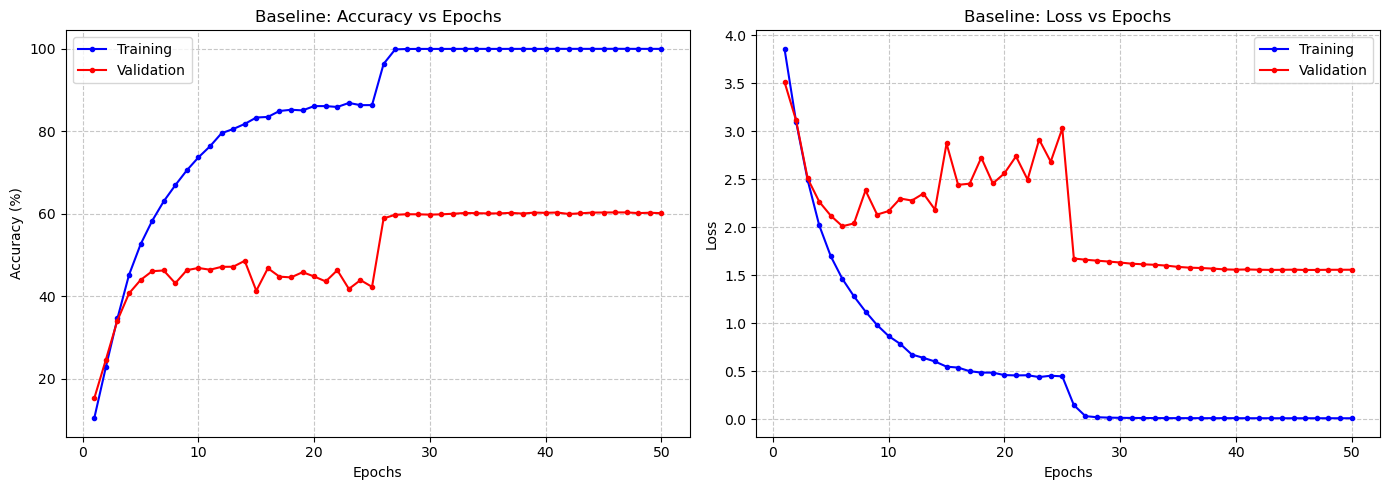

In [8]:
# Load best checkpoint
baseline_model.load_state_dict(torch.load(BASELINE_CKPT, map_location=device))
print("Loaded best baseline checkpoint.")

# Test
baseline_test_acc = evaluate_test(baseline_model, test_loader, device)

# Plot training curves
plot_training_curves(baseline_history, "Baseline", "baseline_metrics_plot.png")

---
The baseline ResNet-18 model was trained on the CIFAR-100 dataset for a fixed number of epochs using a consistent training protocol and a fixed random seed. To evaluate learning dynamics and generalization behavior, training and validation accuracy and loss were recorded at each epoch.

The training curves show that the model achieves near-perfect training accuracy with training loss approaching zero, indicating sufficient model capacity to fit the training data. However, validation accuracy saturates at approximately 60%, while validation loss remains significantly higher than training loss. This divergence between training and validation performance indicates strong overfitting.

Final evaluation on the held-out test set yields a test accuracy of approximately 60%, consistent with validation performance. This confirms that the model generalizes only partially to unseen data, despite achieving extremely high confidence on many predictions.

Importantly, this baseline behavior is intentional and desirable for stress-testing. The presence of overfitting and high-confidence predictions provides a suitable foundation for failure case analysis and explainability-driven investigation in subsequent sections.


## A3. Baseline Failure Case Discovery

Discovering baseline failure cases...
Total baseline failures: 3931
Saved 'baseline_failure_grid.png'


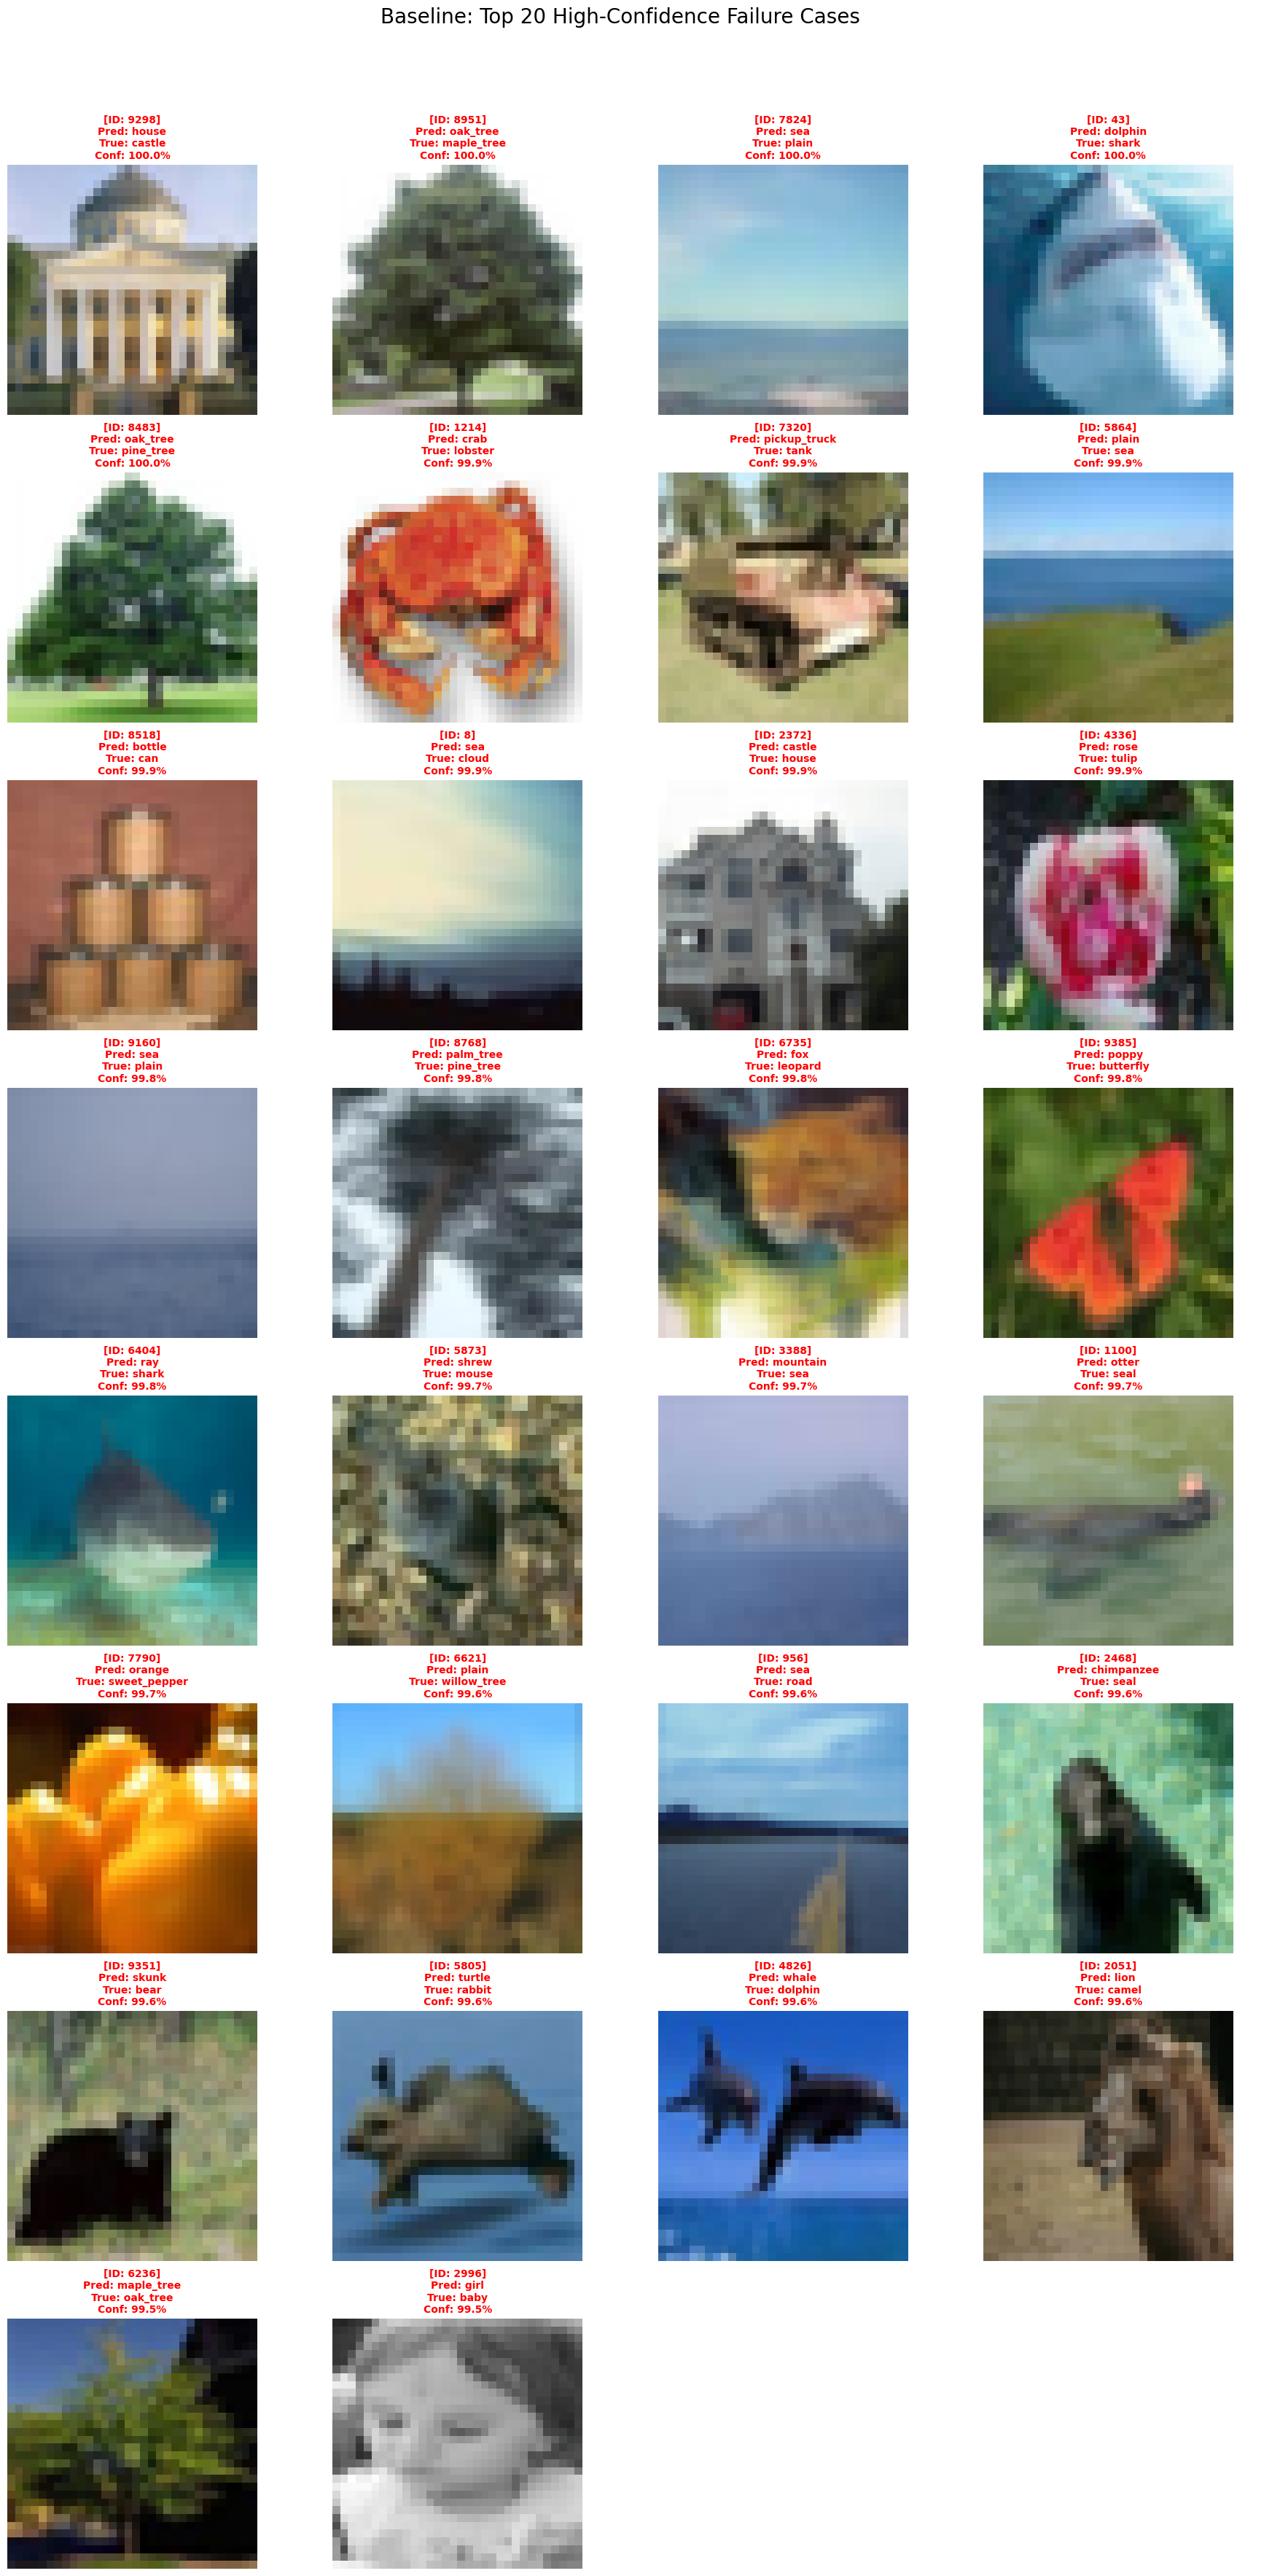

In [9]:
print("Discovering baseline failure cases...")
baseline_failures = discover_failures(baseline_model, test_loader, device)
print(f"Total baseline failures: {len(baseline_failures)}")

# Plot top 20
plot_top_failures(
    baseline_failures, classes,
    "Baseline: Top 20 High-Confidence Failure Cases",
    "baseline_failure_grid.png"
)

---
To analyze where and how the baseline CNN fails, we systematically examine incorrect predictions on the test set. For each test sample, the model’s predicted class and corresponding softmax confidence score are recorded. Failure cases are defined as instances where the predicted label does not match the ground-truth label.

Rather than selecting failures arbitrarily, we focus on *high-confidence misclassifications*, where the model assigns a large probability to an incorrect class. Such cases are particularly concerning, as they indicate overconfident and potentially unreliable behavior.

All incorrect predictions are ranked by confidence score, and a candidate pool of the most confident failures is visualized. From this pool, a subset of failure cases is selected to represent distinct failure mechanisms, such as background bias, fine-grained class confusion, texture-based scene misclassification, and foreground saliency dominance.

These selected failure cases form the basis for deeper qualitative analysis and explainability experiments in the following sections.


## A4. Selected Failure Cases & Hypotheses

Saved 'baseline_selected_failures.png'


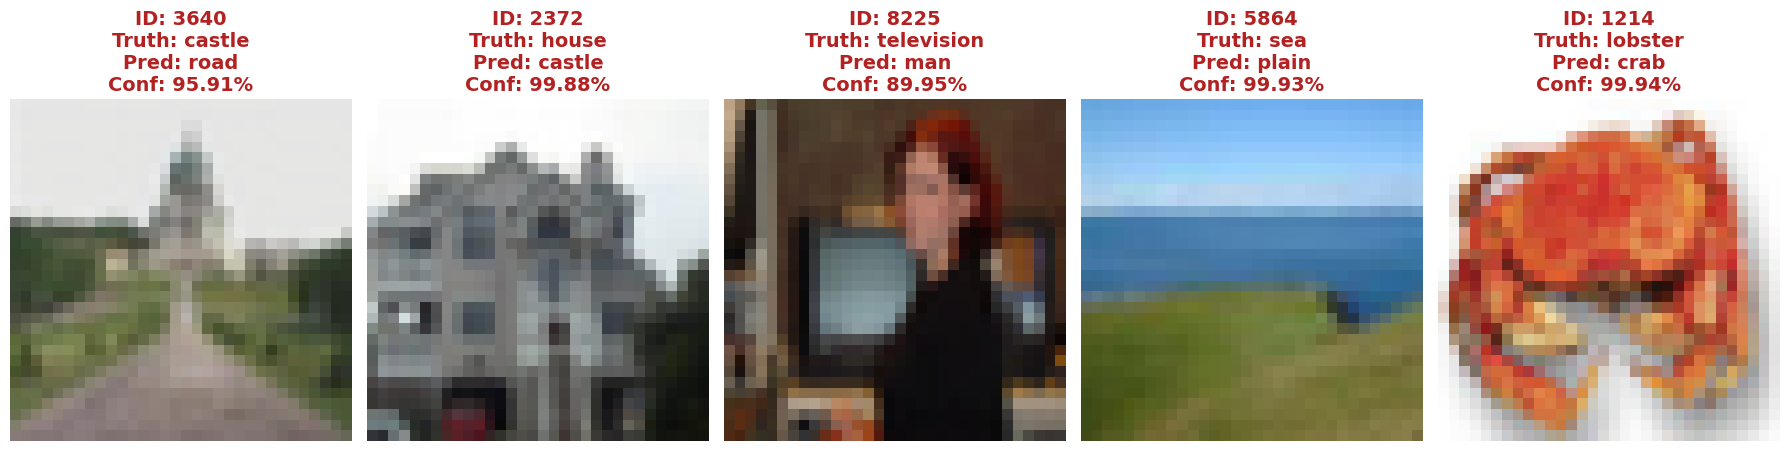

In [10]:
# Our 3 selected failure case IDs
selected_ids = [3640, 2372, 8225, 5864, 1214]

# Plot selected failures
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
for i, target_id in enumerate(selected_ids):
    case = next((item for item in baseline_failures if item[4] == target_id), None)
    if case:
        conf, pred_l, true_l, img_t, ds_idx = case
        axes[i].imshow(unnormalize(img_t))
        axes[i].set_title(
            f"ID: {ds_idx}\nTruth: {classes[true_l]}\nPred: {classes[pred_l]}\nConf: {conf:.2f}%",
            fontsize=14, fontweight='bold', color='#B22222'
        )
        axes[i].axis('off')
plt.tight_layout()
plt.savefig('baseline_selected_failures.png', dpi=300)
print("Saved 'baseline_selected_failures.png'")
plt.show()

Saved 'baseline_failure_analysis_report.png'


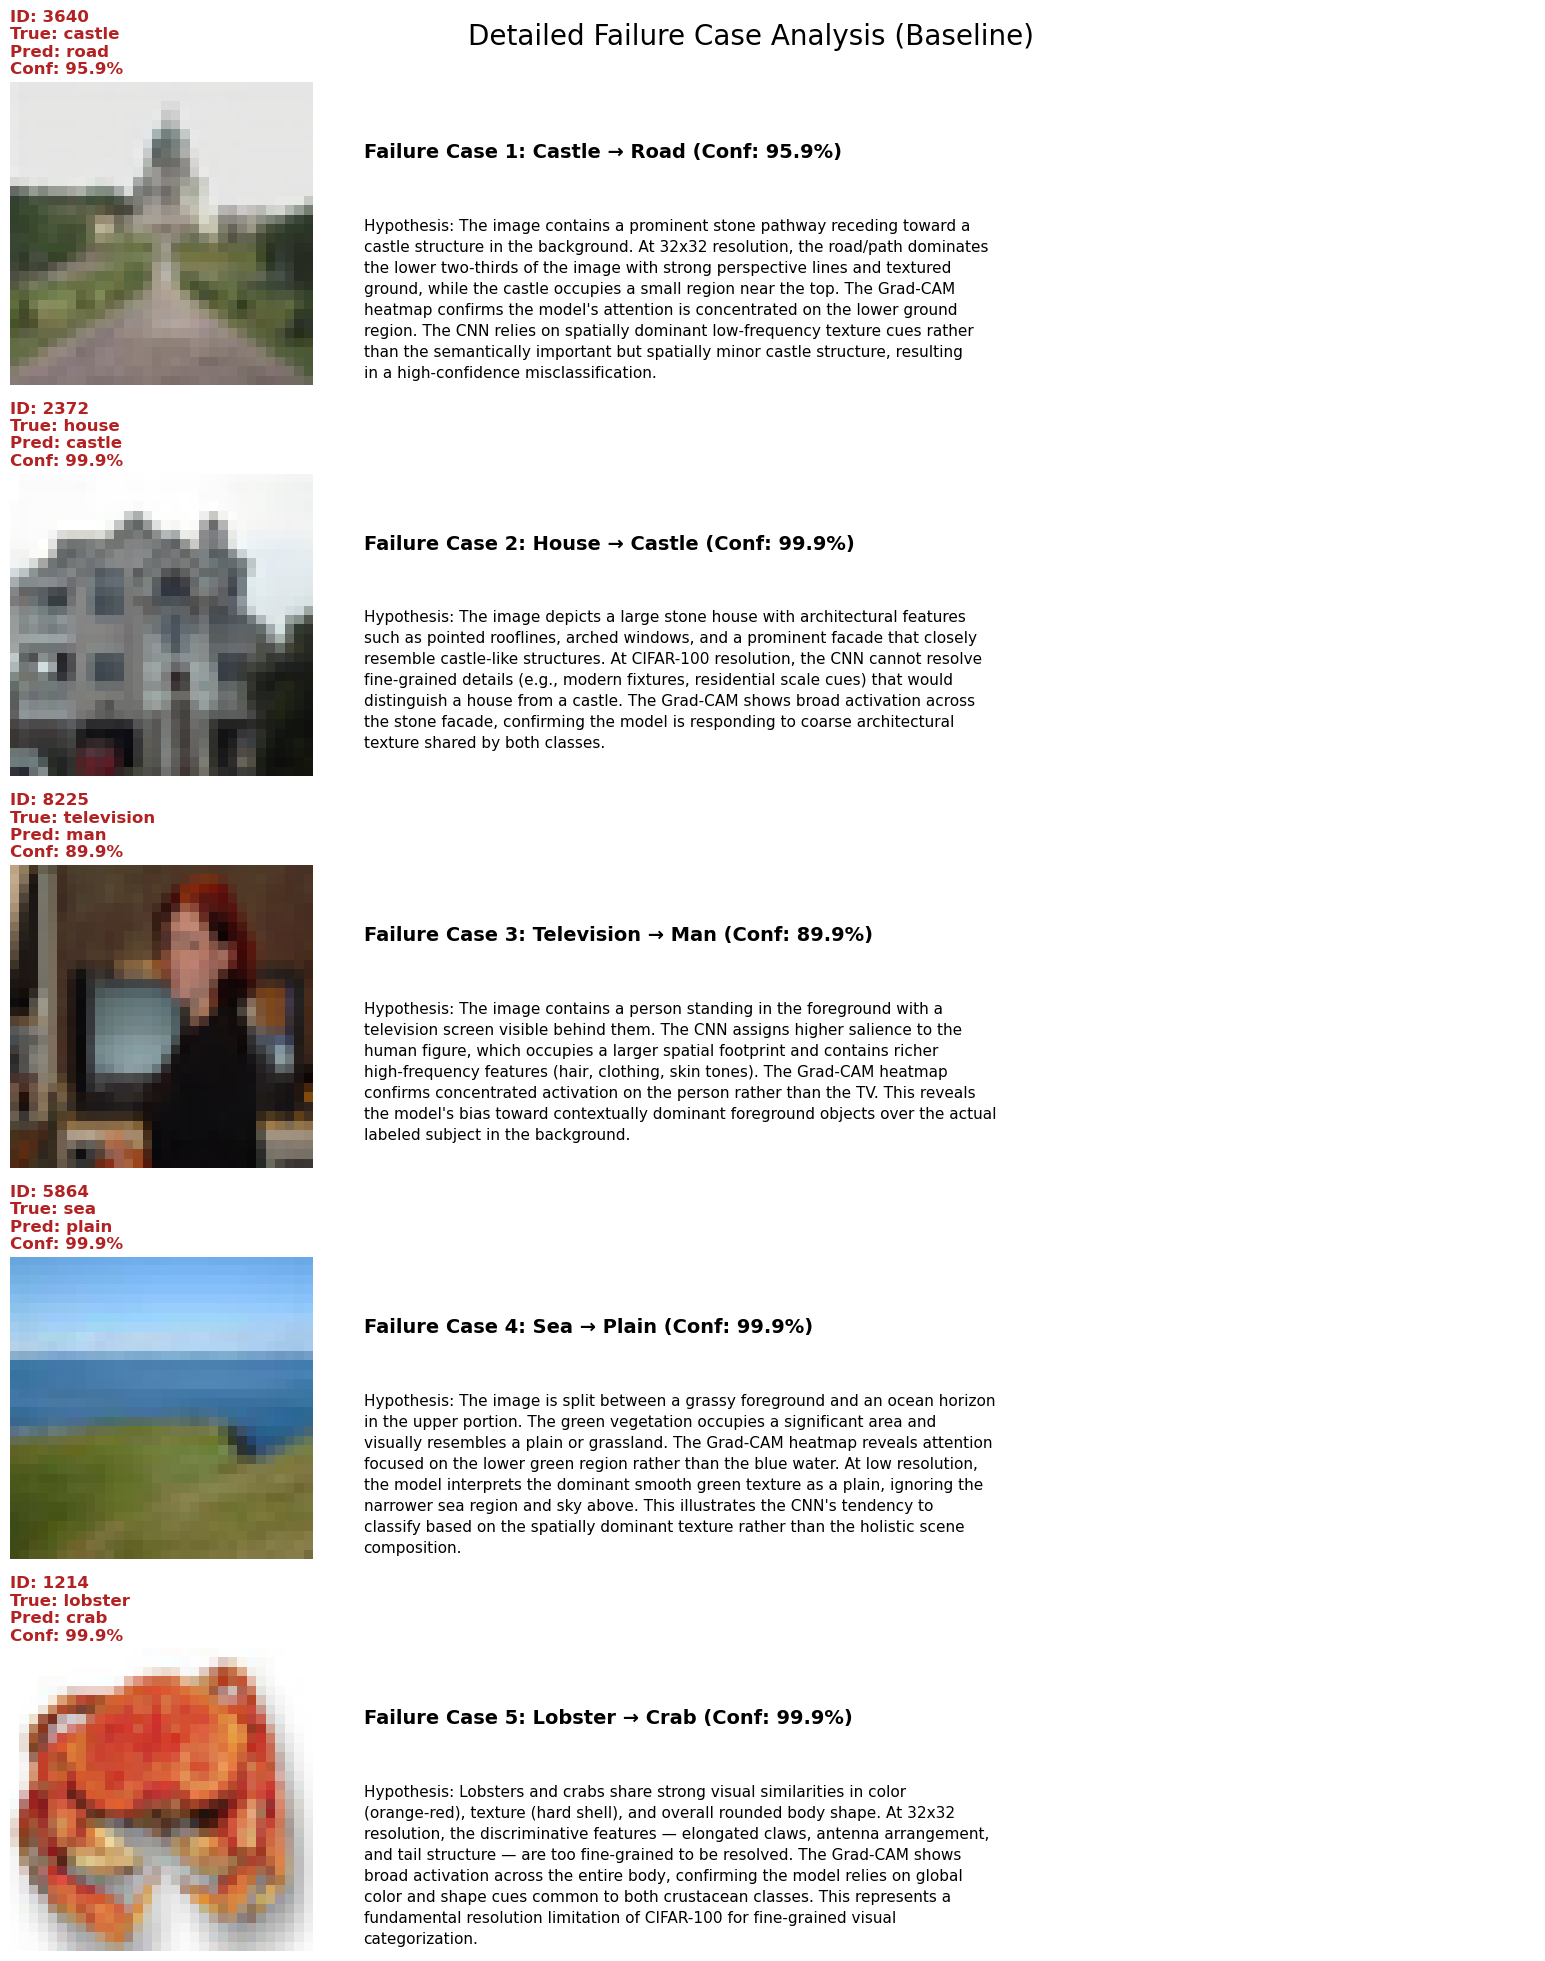

In [33]:
# ============================================================
# CORRECTED HYPOTHESIS CELL — Replace Cell 22 in your notebook
# ============================================================

# Hypotheses visualization
analysis_data = {
    3640: {
        "title": "Failure Case 1: Castle \u2192 Road (Conf: 95.9%)",
        "text": (
            "Hypothesis: The image contains a prominent stone pathway receding toward "
            "a castle structure in the background. At 32x32 resolution, the road/path "
            "dominates the lower two-thirds of the image with strong perspective lines "
            "and textured ground, while the castle occupies a small region near the top. "
            "The Grad-CAM heatmap confirms the model's attention is concentrated on the "
            "lower ground region. The CNN relies on spatially dominant low-frequency "
            "texture cues rather than the semantically important but spatially minor "
            "castle structure, resulting in a high-confidence misclassification."
        )
    },
    2372: {
        "title": "Failure Case 2: House \u2192 Castle (Conf: 99.9%)",
        "text": (
            "Hypothesis: The image depicts a large stone house with architectural "
            "features such as pointed rooflines, arched windows, and a prominent facade "
            "that closely resemble castle-like structures. At CIFAR-100 resolution, the "
            "CNN cannot resolve fine-grained details (e.g., modern fixtures, residential "
            "scale cues) that would distinguish a house from a castle. The Grad-CAM "
            "shows broad activation across the stone facade, confirming the model is "
            "responding to coarse architectural texture shared by both classes."
        )
    },
    8225: {
        "title": "Failure Case 3: Television \u2192 Man (Conf: 89.9%)",
        "text": (
            "Hypothesis: The image contains a person standing in the foreground with a "
            "television screen visible behind them. The CNN assigns higher salience to "
            "the human figure, which occupies a larger spatial footprint and contains "
            "richer high-frequency features (hair, clothing, skin tones). The Grad-CAM "
            "heatmap confirms concentrated activation on the person rather than the TV. "
            "This reveals the model's bias toward contextually dominant foreground "
            "objects over the actual labeled subject in the background."
        )
    },
    5864: {
        "title": "Failure Case 4: Sea \u2192 Plain (Conf: 99.9%)",
        "text": (
            "Hypothesis: The image is split between a grassy foreground and an ocean "
            "horizon in the upper portion. The green vegetation occupies a significant "
            "area and visually resembles a plain or grassland. The Grad-CAM heatmap "
            "reveals attention focused on the lower green region rather than the blue "
            "water. At low resolution, the model interprets the dominant smooth green "
            "texture as a plain, ignoring the narrower sea region and sky above. This "
            "illustrates the CNN's tendency to classify based on the spatially dominant "
            "texture rather than the holistic scene composition."
        )
    },
    1214: {
        "title": "Failure Case 5: Lobster \u2192 Crab (Conf: 99.9%)",
        "text": (
            "Hypothesis: Lobsters and crabs share strong visual similarities in color "
            "(orange-red), texture (hard shell), and overall rounded body shape. At "
            "32x32 resolution, the discriminative features — elongated claws, antenna "
            "arrangement, and tail structure — are too fine-grained to be resolved. "
            "The Grad-CAM shows broad activation across the entire body, confirming the "
            "model relies on global color and shape cues common to both crustacean "
            "classes. This represents a fundamental resolution limitation of CIFAR-100 "
            "for fine-grained visual categorization."
        )
    }
}

fig, axes = plt.subplots(5, 2, figsize=(16, 20), gridspec_kw={'width_ratios': [1, 3]})
fig.suptitle("Detailed Failure Case Analysis (Baseline)", fontsize=20, y=0.98)

for row_idx, target_id in enumerate(selected_ids):
    case = next((item for item in baseline_failures if item[4] == target_id), None)
    if case:
        conf, pred_l, true_l, img_t, ds_idx = case

        ax_img = axes[row_idx, 0]
        ax_img.imshow(unnormalize(img_t), interpolation='nearest')
        ax_img.set_title(
            f"ID: {ds_idx}\nTrue: {classes[true_l]}\nPred: {classes[pred_l]}\nConf: {conf:.1f}%",
            fontsize=12, fontweight='bold', color='#B22222', loc='left'
        )
        ax_img.axis('off')

        ax_text = axes[row_idx, 1]
        data = analysis_data[target_id]
        ax_text.text(0.0, 0.8, data['title'], fontsize=14, fontweight='bold', va='top')
        ax_text.text(0.0, 0.55, textwrap.fill(data['text'], width=80), fontsize=11, va='top', linespacing=1.5)
        ax_text.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('baseline_failure_analysis_report.png', dpi=300)
print("Saved 'baseline_failure_analysis_report.png'")
plt.show()

## A5. Baseline Grad-CAM Explainability

Saved 'baseline_gradcam.png'


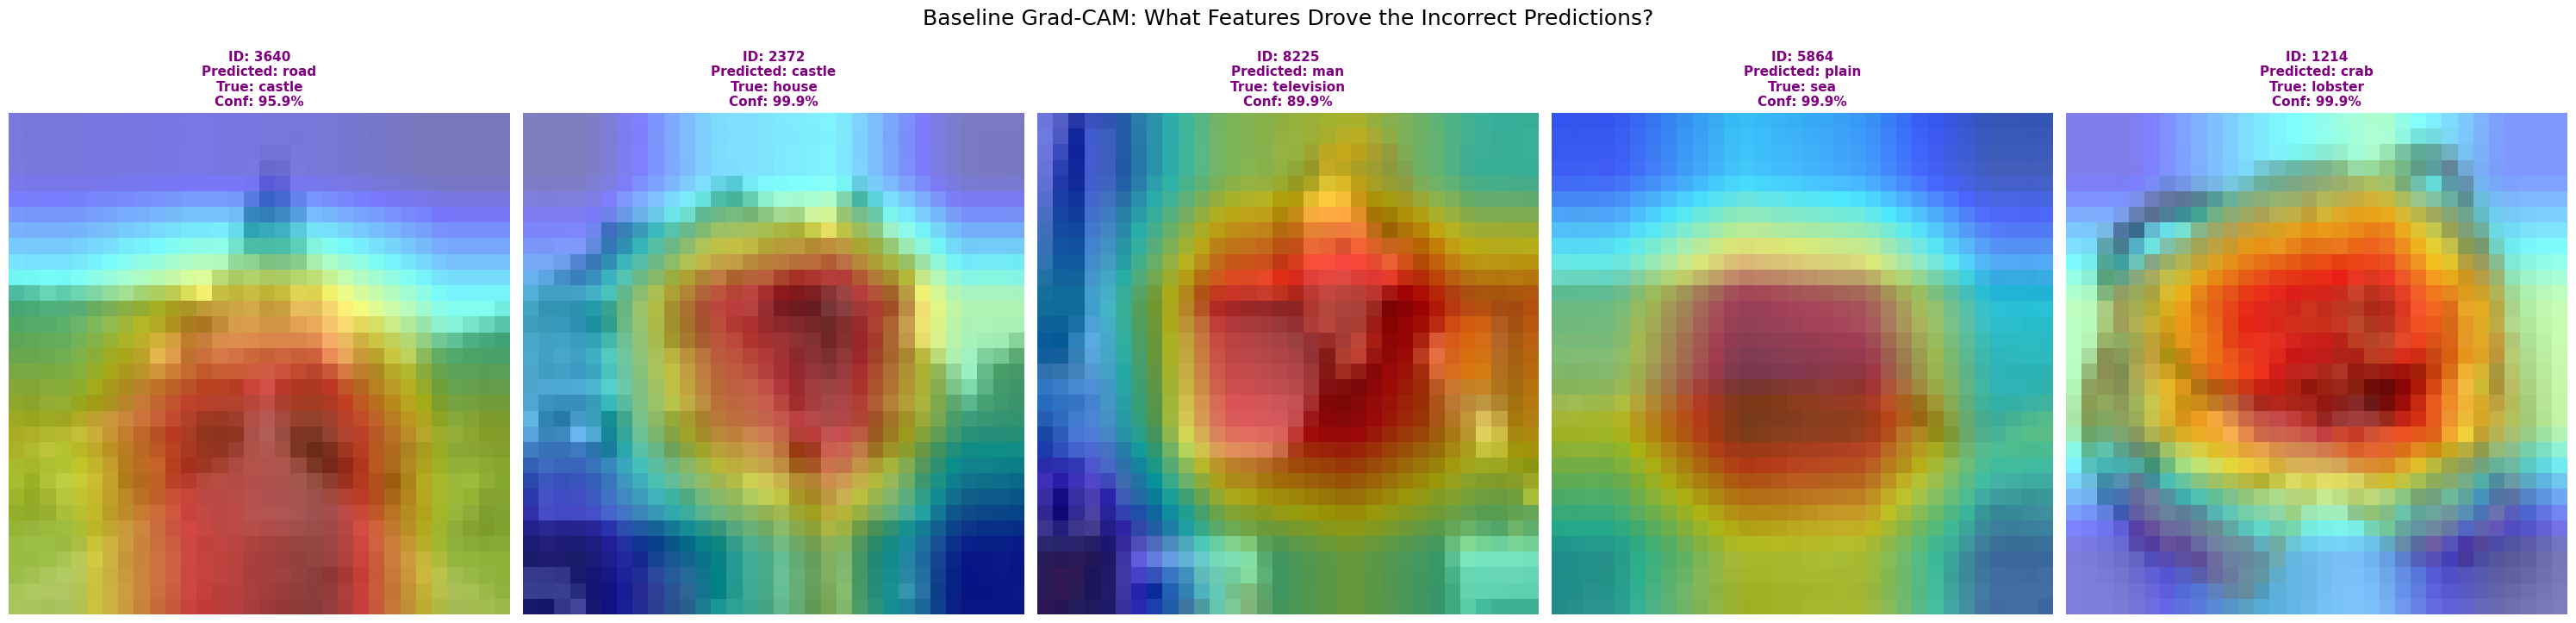

In [12]:
generate_gradcam(
    model=baseline_model,
    failures=baseline_failures,
    target_indices=selected_ids,
    classes=classes,
    device=device,
    title="Baseline Grad-CAM: What Features Drove the Incorrect Predictions?",
    save_name="baseline_gradcam.png"
)

---
To better understand the internal decision-making process of the CNN for selected failure cases, we apply Grad-CAM (Gradient-weighted Class Activation Mapping). Grad-CAM highlights spatial regions of the input image that most strongly influence the model’s prediction for a given class.

For each selected failure case, Grad-CAM is computed with respect to the *predicted (incorrect) class* using the final convolutional block of the ResNet-18 architecture. This choice ensures that the visualization reflects high-level semantic features while preserving spatial information.

The resulting Grad-CAM heatmaps are overlaid on the original input images and analyzed qualitatively. These visualizations allow us to assess whether the model focuses on semantically meaningful regions or relies on spurious cues such as background textures, coarse shapes, or dominant foreground elements.

In several cases, Grad-CAM supports the proposed failure hypotheses by revealing attention on irrelevant or misleading regions. In other cases, the explanations partially contradict initial assumptions, highlighting the limitations and ambiguity of explainability methods themselves. Together, these observations provide valuable insight into the robustness and reliability of CNN predictions.

---
# PART B: Constrained Improvement — CutMix Augmentation
---

**Single Modification:** CutMix data augmentation applied at the batch level during training.

**Rationale:** Our Grad-CAM analysis revealed that the baseline model fixates on small spatial
regions (e.g., the road texture in the castle image). CutMix forces the model to make
predictions even when parts of an image are replaced by patches from other classes, encouraging
distributed spatial attention and reducing overconfident predictions.

## B1. Initialize & Train CutMix Model

In [13]:
set_seed()

# Reset train transform back to training augmentation (val override may have changed it)
full_train_dataset.transform = transform_train

# Fresh model — identical architecture
cutmix_model = create_resnet18_cifar100().to(device)
print("CutMix ResNet-18 initialized (from scratch).")

# Hyperparameters — IDENTICAL to baseline except for CutMix in the loop
CUTMIX_EPOCHS = 50
CUTMIX_LR     = 0.1
CUTMIX_CKPT   = "best_cutmix_resnet18.pth"

cutmix_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train with CutMix
cutmix_history = train_cutmix(
    model=cutmix_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=CUTMIX_EPOCHS,
    lr=CUTMIX_LR,
    criterion=cutmix_criterion,
    checkpoint_path=CUTMIX_CKPT,
    cutmix_alpha=1.0,
    cutmix_prob=0.5
)

np.save('cutmix_training_history.npy', cutmix_history)

CutMix ResNet-18 initialized (from scratch).
Starting CutMix training for 50 epochs (alpha=1.0, prob=0.5)...


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.74it/s]


Epoch 1: Train Loss=4.2431 Acc=6.76% | Val Loss=3.8958 Acc=11.90%
  >>> Val Acc improved 0.00% -> 11.90%. Saving...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.05it/s]


Epoch 2: Train Loss=3.9060 Acc=13.15% | Val Loss=3.5963 Acc=19.26%
  >>> Val Acc improved 11.90% -> 19.26%. Saving...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 69.69it/s]


Epoch 3: Train Loss=3.6505 Acc=18.80% | Val Loss=3.3406 Acc=25.74%
  >>> Val Acc improved 19.26% -> 25.74%. Saving...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.76it/s]


Epoch 4: Train Loss=3.3903 Acc=25.03% | Val Loss=3.1425 Acc=30.62%
  >>> Val Acc improved 25.74% -> 30.62%. Saving...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 72.61it/s]


Epoch 5: Train Loss=3.2200 Acc=29.66% | Val Loss=2.8954 Acc=34.88%
  >>> Val Acc improved 30.62% -> 34.88%. Saving...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.46it/s]


Epoch 6: Train Loss=3.0656 Acc=33.79% | Val Loss=2.6610 Acc=42.00%
  >>> Val Acc improved 34.88% -> 42.00%. Saving...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 67.14it/s]


Epoch 7: Train Loss=2.9823 Acc=36.31% | Val Loss=2.5714 Acc=44.34%
  >>> Val Acc improved 42.00% -> 44.34%. Saving...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 71.07it/s]


Epoch 8: Train Loss=2.8821 Acc=39.21% | Val Loss=2.6250 Acc=43.88%


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 64.93it/s]


Epoch 9: Train Loss=2.7787 Acc=41.82% | Val Loss=2.4927 Acc=46.84%
  >>> Val Acc improved 44.34% -> 46.84%. Saving...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 63.19it/s]


Epoch 10: Train Loss=2.7144 Acc=43.86% | Val Loss=2.5618 Acc=45.30%


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 64.12it/s]


Epoch 11: Train Loss=2.6760 Acc=44.86% | Val Loss=2.4313 Acc=48.68%
  >>> Val Acc improved 46.84% -> 48.68%. Saving...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.52it/s]


Epoch 12: Train Loss=2.6688 Acc=45.37% | Val Loss=2.3119 Acc=50.98%
  >>> Val Acc improved 48.68% -> 50.98%. Saving...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.45it/s]


Epoch 13: Train Loss=2.6367 Acc=46.56% | Val Loss=2.6531 Acc=43.18%


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.44it/s]


Epoch 14: Train Loss=2.5675 Acc=48.03% | Val Loss=2.5527 Acc=45.12%


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 70.00it/s]


Epoch 15: Train Loss=2.5578 Acc=48.75% | Val Loss=2.2518 Acc=53.24%
  >>> Val Acc improved 50.98% -> 53.24%. Saving...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 69.18it/s]


Epoch 16: Train Loss=2.5880 Acc=47.88% | Val Loss=2.4723 Acc=47.54%


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.06it/s]


Epoch 17: Train Loss=2.5948 Acc=48.09% | Val Loss=2.5126 Acc=46.44%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 67.25it/s]


Epoch 18: Train Loss=2.4787 Acc=50.88% | Val Loss=2.3428 Acc=51.92%


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.17it/s]


Epoch 19: Train Loss=2.4996 Acc=50.57% | Val Loss=2.4038 Acc=50.18%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.82it/s]


Epoch 20: Train Loss=2.5623 Acc=48.99% | Val Loss=2.2849 Acc=53.38%
  >>> Val Acc improved 53.24% -> 53.38%. Saving...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.97it/s]


Epoch 21: Train Loss=2.4637 Acc=51.55% | Val Loss=2.2973 Acc=53.38%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.88it/s]


Epoch 22: Train Loss=2.4907 Acc=50.79% | Val Loss=2.2397 Acc=54.28%
  >>> Val Acc improved 53.38% -> 54.28%. Saving...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 72.11it/s]


Epoch 23: Train Loss=2.4480 Acc=51.86% | Val Loss=2.4324 Acc=50.76%


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.84it/s]


Epoch 24: Train Loss=2.4960 Acc=50.87% | Val Loss=2.2784 Acc=52.54%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.30it/s]


Epoch 25: Train Loss=2.5064 Acc=50.51% | Val Loss=2.3283 Acc=52.12%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.34it/s]


Epoch 26: Train Loss=2.2044 Acc=59.92% | Val Loss=1.6859 Acc=71.10%
  >>> Val Acc improved 54.28% -> 71.10%. Saving...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 72.76it/s]


Epoch 27: Train Loss=2.0599 Acc=64.44% | Val Loss=1.6548 Acc=72.30%
  >>> Val Acc improved 71.10% -> 72.30%. Saving...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.45it/s]


Epoch 28: Train Loss=1.9867 Acc=66.60% | Val Loss=1.6355 Acc=72.70%
  >>> Val Acc improved 72.30% -> 72.70%. Saving...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 67.51it/s]


Epoch 29: Train Loss=1.9244 Acc=68.37% | Val Loss=1.6107 Acc=73.60%
  >>> Val Acc improved 72.70% -> 73.60%. Saving...


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 69.78it/s]


Epoch 30: Train Loss=1.9524 Acc=67.76% | Val Loss=1.6341 Acc=73.10%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 68.54it/s]


Epoch 31: Train Loss=1.8769 Acc=69.82% | Val Loss=1.5871 Acc=73.88%
  >>> Val Acc improved 73.60% -> 73.88%. Saving...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.48it/s]


Epoch 32: Train Loss=1.9936 Acc=66.62% | Val Loss=1.6057 Acc=73.76%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.29it/s]


Epoch 33: Train Loss=1.9082 Acc=68.87% | Val Loss=1.5828 Acc=74.20%
  >>> Val Acc improved 73.88% -> 74.20%. Saving...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.57it/s]


Epoch 34: Train Loss=1.9403 Acc=68.16% | Val Loss=1.5994 Acc=73.98%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.01it/s]


Epoch 35: Train Loss=1.8881 Acc=69.75% | Val Loss=1.6140 Acc=73.72%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.90it/s]


Epoch 36: Train Loss=1.8845 Acc=70.15% | Val Loss=1.5945 Acc=73.44%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.29it/s]


Epoch 37: Train Loss=1.8187 Acc=71.93% | Val Loss=1.5950 Acc=74.20%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 69.38it/s]


Epoch 38: Train Loss=1.7937 Acc=72.84% | Val Loss=1.5877 Acc=75.24%
  >>> Val Acc improved 74.20% -> 75.24%. Saving...


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 70.08it/s]


Epoch 39: Train Loss=1.8454 Acc=71.93% | Val Loss=1.5936 Acc=73.92%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.81it/s]


Epoch 40: Train Loss=1.8421 Acc=71.53% | Val Loss=1.6036 Acc=73.32%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.27it/s]


Epoch 41: Train Loss=1.7940 Acc=73.49% | Val Loss=1.5413 Acc=75.80%
  >>> Val Acc improved 75.24% -> 75.80%. Saving...


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.68it/s]


Epoch 42: Train Loss=1.7076 Acc=75.87% | Val Loss=1.5236 Acc=76.76%
  >>> Val Acc improved 75.80% -> 76.76%. Saving...


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.50it/s]


Epoch 43: Train Loss=1.7192 Acc=75.74% | Val Loss=1.5301 Acc=75.86%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 58.03it/s]


Epoch 44: Train Loss=1.7359 Acc=75.19% | Val Loss=1.5221 Acc=76.56%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 59.07it/s]


Epoch 45: Train Loss=1.5964 Acc=79.56% | Val Loss=1.5154 Acc=76.74%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 59.74it/s]


Epoch 46: Train Loss=1.6219 Acc=78.21% | Val Loss=1.5289 Acc=76.96%
  >>> Val Acc improved 76.76% -> 76.96%. Saving...


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 62.05it/s]


Epoch 47: Train Loss=1.6294 Acc=78.03% | Val Loss=1.5176 Acc=76.62%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 61.36it/s]


Epoch 48: Train Loss=1.6946 Acc=76.46% | Val Loss=1.5245 Acc=76.02%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 59.86it/s]


Epoch 49: Train Loss=1.7339 Acc=75.19% | Val Loss=1.5299 Acc=76.48%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:00<00:00, 60.32it/s]

Epoch 50: Train Loss=1.6775 Acc=76.95% | Val Loss=1.5231 Acc=76.74%
Training Complete! Best Val Acc: 76.96%


## B2. CutMix Test Evaluation & Training Curves

Loaded best CutMix checkpoint.


Testing: 100%|██████████| 79/79 [00:00<00:00, 99.41it/s] 


Test Accuracy: 75.70%
Saved 'cutmix_metrics_plot.png'


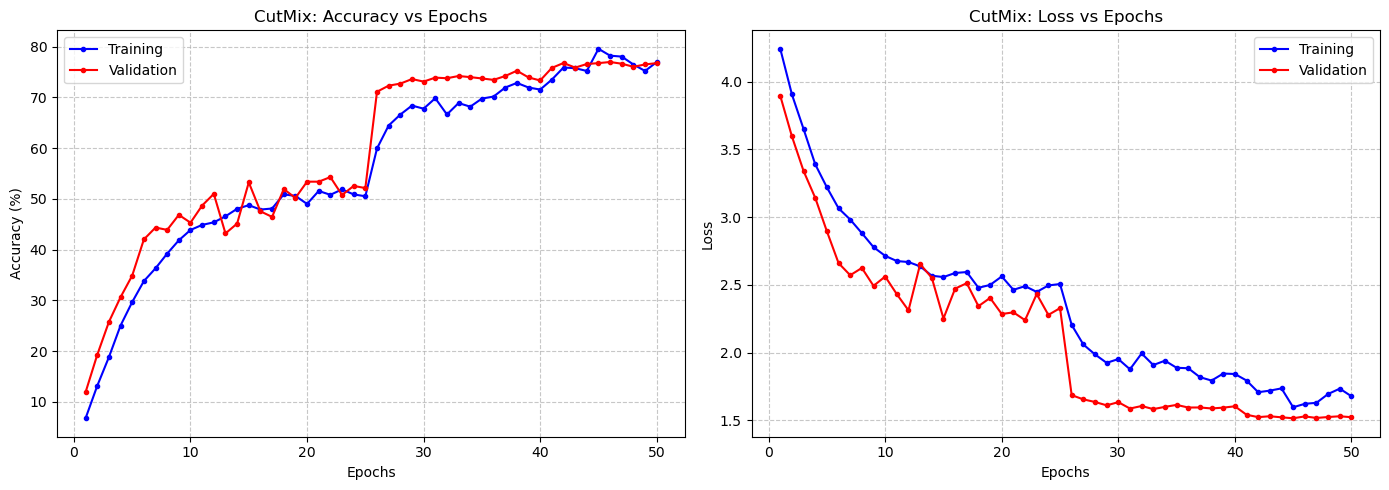

In [14]:
cutmix_model.load_state_dict(torch.load(CUTMIX_CKPT, map_location=device))
print("Loaded best CutMix checkpoint.")

cutmix_test_acc = evaluate_test(cutmix_model, test_loader, device)

plot_training_curves(cutmix_history, "CutMix", "cutmix_metrics_plot.png")

---
Analysis of the baseline model reveals multiple failure mechanisms, including over-reliance on background textures, difficulty with fine-grained class distinctions, and overconfident incorrect predictions. These observations motivate the need for a constrained modification aimed at improving model robustness without fundamentally altering the training setup.

To ensure interpretability of experimental outcomes, exactly one modification is introduced. This constraint allows us to isolate the effect of the change and avoid confounding factors that would arise from applying multiple improvements simultaneously.

## B3. CutMix Failure Case Discovery

Discovering CutMix failure cases...
Total CutMix failures: 2430
Saved 'cutmix_failure_grid.png'


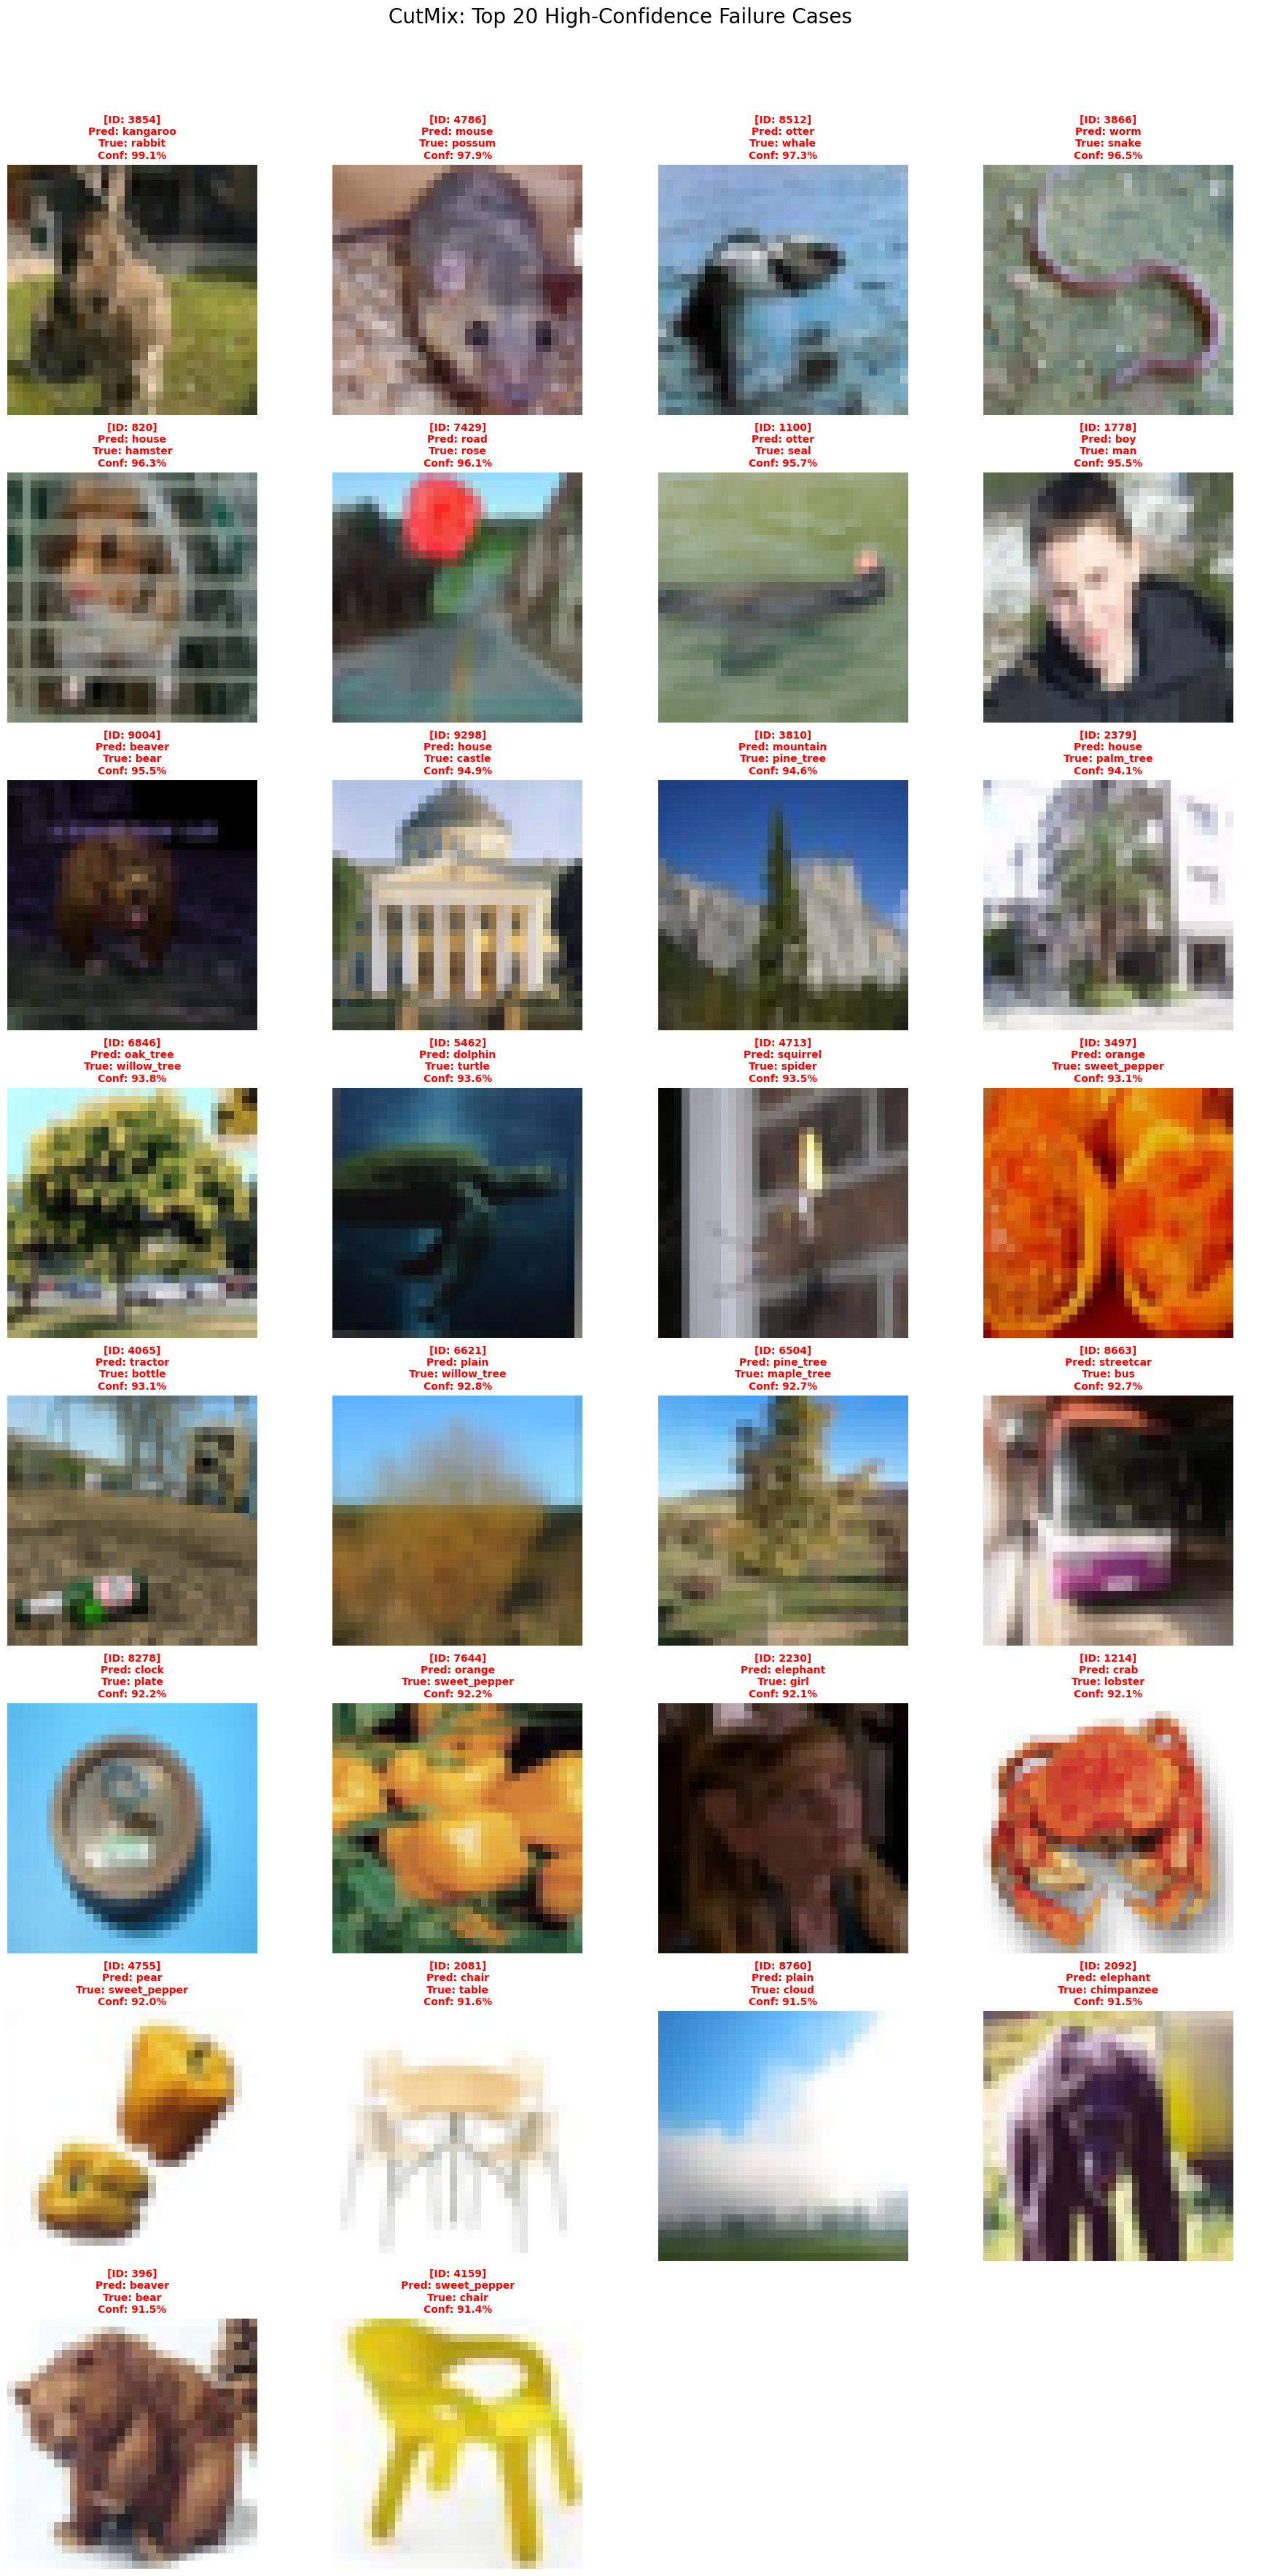

In [15]:
print("Discovering CutMix failure cases...")
cutmix_failures = discover_failures(cutmix_model, test_loader, device)
print(f"Total CutMix failures: {len(cutmix_failures)}")

plot_top_failures(
    cutmix_failures, classes,
    "CutMix: Top 20 High-Confidence Failure Cases",
    "cutmix_failure_grid.png"
)

---
A single constrained modification is applied to the baseline training pipeline while keeping all other factors unchanged, including architecture, dataset splits, random seed, and optimization settings. This modification is selected to address at least one of the observed failure modes identified in the baseline analysis.

By limiting the scope of change, we ensure that any observed differences in performance or behavior can be attributed directly to the applied modification rather than incidental variations in training.

## B4. CutMix Grad-CAM on Same Failure Cases

Checking original failure cases under CutMix model...
  ID 3640: Still wrong — Pred=road, True=castle, Conf=63.5%
  ID 2372: CORRECTED by CutMix!
  ID 8225: Still wrong — Pred=man, True=television, Conf=37.2%
  ID 5864: CORRECTED by CutMix!
  ID 1214: Still wrong — Pred=crab, True=lobster, Conf=92.1%
Saved 'cutmix_gradcam.png'


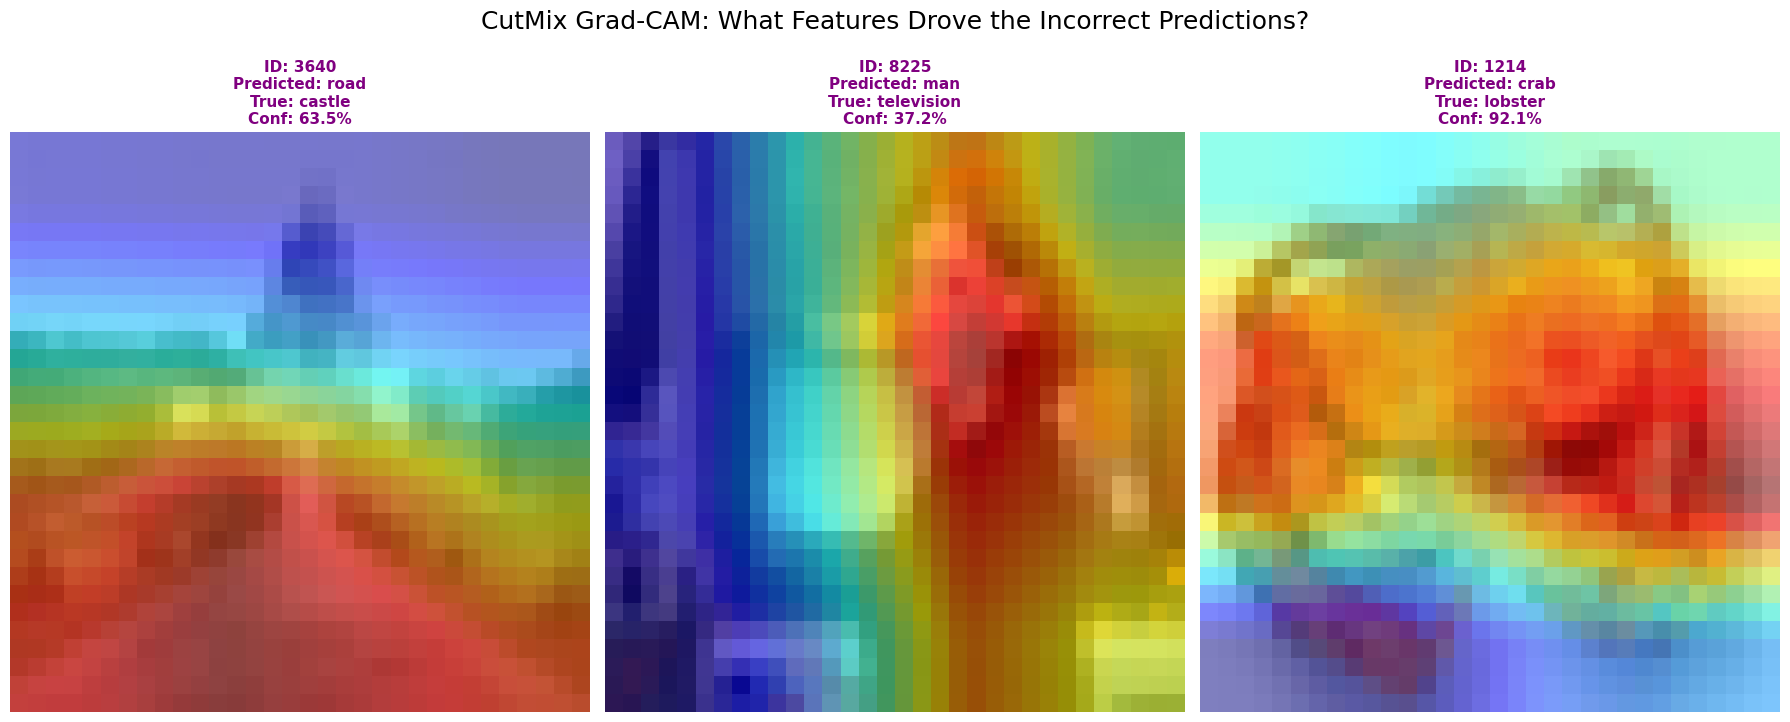

In [16]:
# Check if our original 3 cases are still failures under CutMix
print("Checking original failure cases under CutMix model...")
for target_id in selected_ids:
    case = next((item for item in cutmix_failures if item[4] == target_id), None)
    if case:
        conf, pred_l, true_l, _, _ = case
        print(f"  ID {target_id}: Still wrong — Pred={classes[pred_l]}, True={classes[true_l]}, Conf={conf:.1f}%")
    else:
        print(f"  ID {target_id}: CORRECTED by CutMix!")

# Generate Grad-CAM for cases that are still wrong
still_wrong_ids = [tid for tid in selected_ids
                   if any(item[4] == tid for item in cutmix_failures)]

if still_wrong_ids:
    generate_gradcam(
        model=cutmix_model,
        failures=cutmix_failures,
        target_indices=still_wrong_ids,
        classes=classes,
        device=device,
        title="CutMix Grad-CAM: What Features Drove the Incorrect Predictions?",
        save_name="cutmix_gradcam.png"
    )

---
The modified model is evaluated using the same metrics and protocols as the baseline model. Performance is compared in terms of training and validation behavior, test accuracy, and behavior on previously identified failure cases.

While the constrained modification may lead to modest changes in overall accuracy, its primary impact is evaluated qualitatively by examining whether specific failure modes are mitigated. Any observed trade-offs, such as improved robustness at the cost of reduced confidence or accuracy, are explicitly discussed.

---
# PART C: Comparative Analysis — Baseline vs CutMix
---

## C1. Full Test Set Comparison

In [17]:
print("Running both models on full test set...")
base_preds, base_confs, truths = get_all_predictions(baseline_model, test_loader, device)
enh_preds, enh_confs, _        = get_all_predictions(cutmix_model,   test_loader, device)

base_correct = (base_preds == truths)
enh_correct  = (enh_preds  == truths)

print(f"\nBaseline Test Accuracy: {base_correct.mean()*100:.2f}%")
print(f"CutMix   Test Accuracy: {enh_correct.mean()*100:.2f}%")
print(f"Improvement:            +{(enh_correct.mean() - base_correct.mean())*100:.2f}%")

Running both models on full test set...


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 105.15it/s]



Baseline Test Accuracy: 60.69%
CutMix   Test Accuracy: 75.70%
Improvement:            +15.01%


## C2. Sample Category Breakdown

In [18]:
corrected  = (~base_correct) & (enh_correct)     # wrong -> right
worsened   = (base_correct)  & (~enh_correct)    # right -> wrong
both_wrong = (~base_correct) & (~enh_correct)    # wrong in both
both_right = (base_correct)  & (enh_correct)     # right in both

print("=" * 55)
print("CATEGORY BREAKDOWN (out of 10,000 test samples)")
print("=" * 55)
print(f"  Both Correct:                {both_right.sum():>5d}")
print(f"  CORRECTED (wrong -> right):  {corrected.sum():>5d}  <- improvement")
print(f"  WORSENED  (right -> wrong):  {worsened.sum():>5d}  <- regression")
print(f"  Both Wrong (still failing):  {both_wrong.sum():>5d}")
print(f"  Net improvement:             +{corrected.sum() - worsened.sum()} samples")
print("=" * 55)

CATEGORY BREAKDOWN (out of 10,000 test samples)
  Both Correct:                 5632
  CORRECTED (wrong -> right):   1938  <- improvement
  WORSENED  (right -> wrong):    437  <- regression
  Both Wrong (still failing):   1993
  Net improvement:             +1501 samples


## C3. Original Failure Cases — Status Check

In [19]:
print("=" * 70)
print("STATUS OF OUR 3 ORIGINAL FAILURE CASES")
print("=" * 70)

original_failures = {
    3640: "castle -> road",
    5864: "Sea -> Plain",
    8225: "television -> man",
    2372: "castle -> house", 
    1214: "Lobster -> Crab"   
}

for idx, description in original_failures.items():
    base_pred_name = classes[base_preds[idx]]
    base_conf = base_confs[idx] * 100
    enh_pred_name = classes[enh_preds[idx]]
    enh_conf = enh_confs[idx] * 100
    true_name = classes[truths[idx]]

    if enh_correct[idx] and not base_correct[idx]:
        status = "CORRECTED!"
    elif not enh_correct[idx] and not base_correct[idx]:
        conf_delta = enh_conf - base_conf
        status = f"Still wrong (conf shift: {conf_delta:+.1f}%)"
    elif base_correct[idx] and not enh_correct[idx]:
        status = "WORSENED"
    else:
        status = "Correct in both"

    print(f"\n  ID {idx} ({description})")
    print(f"    True:     {true_name}")
    print(f"    Baseline: {base_pred_name} ({base_conf:.1f}%)")
    print(f"    CutMix:   {enh_pred_name} ({enh_conf:.1f}%)")
    print(f"    Status:   {status}")

STATUS OF OUR 3 ORIGINAL FAILURE CASES

  ID 3640 (castle -> road)
    True:     castle
    Baseline: road (95.9%)
    CutMix:   road (63.5%)
    Status:   Still wrong (conf shift: -32.4%)

  ID 5864 (Sea -> Plain)
    True:     sea
    Baseline: plain (99.9%)
    CutMix:   sea (49.6%)
    Status:   CORRECTED!

  ID 8225 (television -> man)
    True:     television
    Baseline: man (89.9%)
    CutMix:   man (37.2%)
    Status:   Still wrong (conf shift: -52.8%)

  ID 2372 (castle -> house)
    True:     house
    Baseline: castle (99.9%)
    CutMix:   house (62.4%)
    Status:   CORRECTED!

  ID 1214 (Lobster -> Crab)
    True:     lobster
    Baseline: crab (99.9%)
    CutMix:   crab (92.1%)
    Status:   Still wrong (conf shift: -7.9%)


## C4. Confidence Shift for Still-Wrong Cases

In [20]:
both_wrong_indices = np.where(both_wrong)[0]

conf_dropped = sum(1 for i in both_wrong_indices if enh_confs[i] - base_confs[i] < -0.01)
conf_increased = sum(1 for i in both_wrong_indices if enh_confs[i] - base_confs[i] > 0.01)
conf_same = len(both_wrong_indices) - conf_dropped - conf_increased

print(f"Among {len(both_wrong_indices)} samples WRONG in both models:")
print(f"  Confidence DECREASED (less overconfident): {conf_dropped}")
print(f"  Confidence INCREASED (more overconfident): {conf_increased}")
print(f"  Confidence roughly same:                   {conf_same}")

if len(both_wrong_indices) > 0:
    avg_base = base_confs[both_wrong_indices].mean() * 100
    avg_enh  = enh_confs[both_wrong_indices].mean() * 100
    print(f"\n  Avg wrong confidence: Baseline={avg_base:.1f}% -> CutMix={avg_enh:.1f}%")

Among 1993 samples WRONG in both models:
  Confidence DECREASED (less overconfident): 1147
  Confidence INCREASED (more overconfident): 784
  Confidence roughly same:                   62

  Avg wrong confidence: Baseline=47.8% -> CutMix=40.8%


## C5. Visualize Corrected Cases

Saved 'corrected_cases.png'


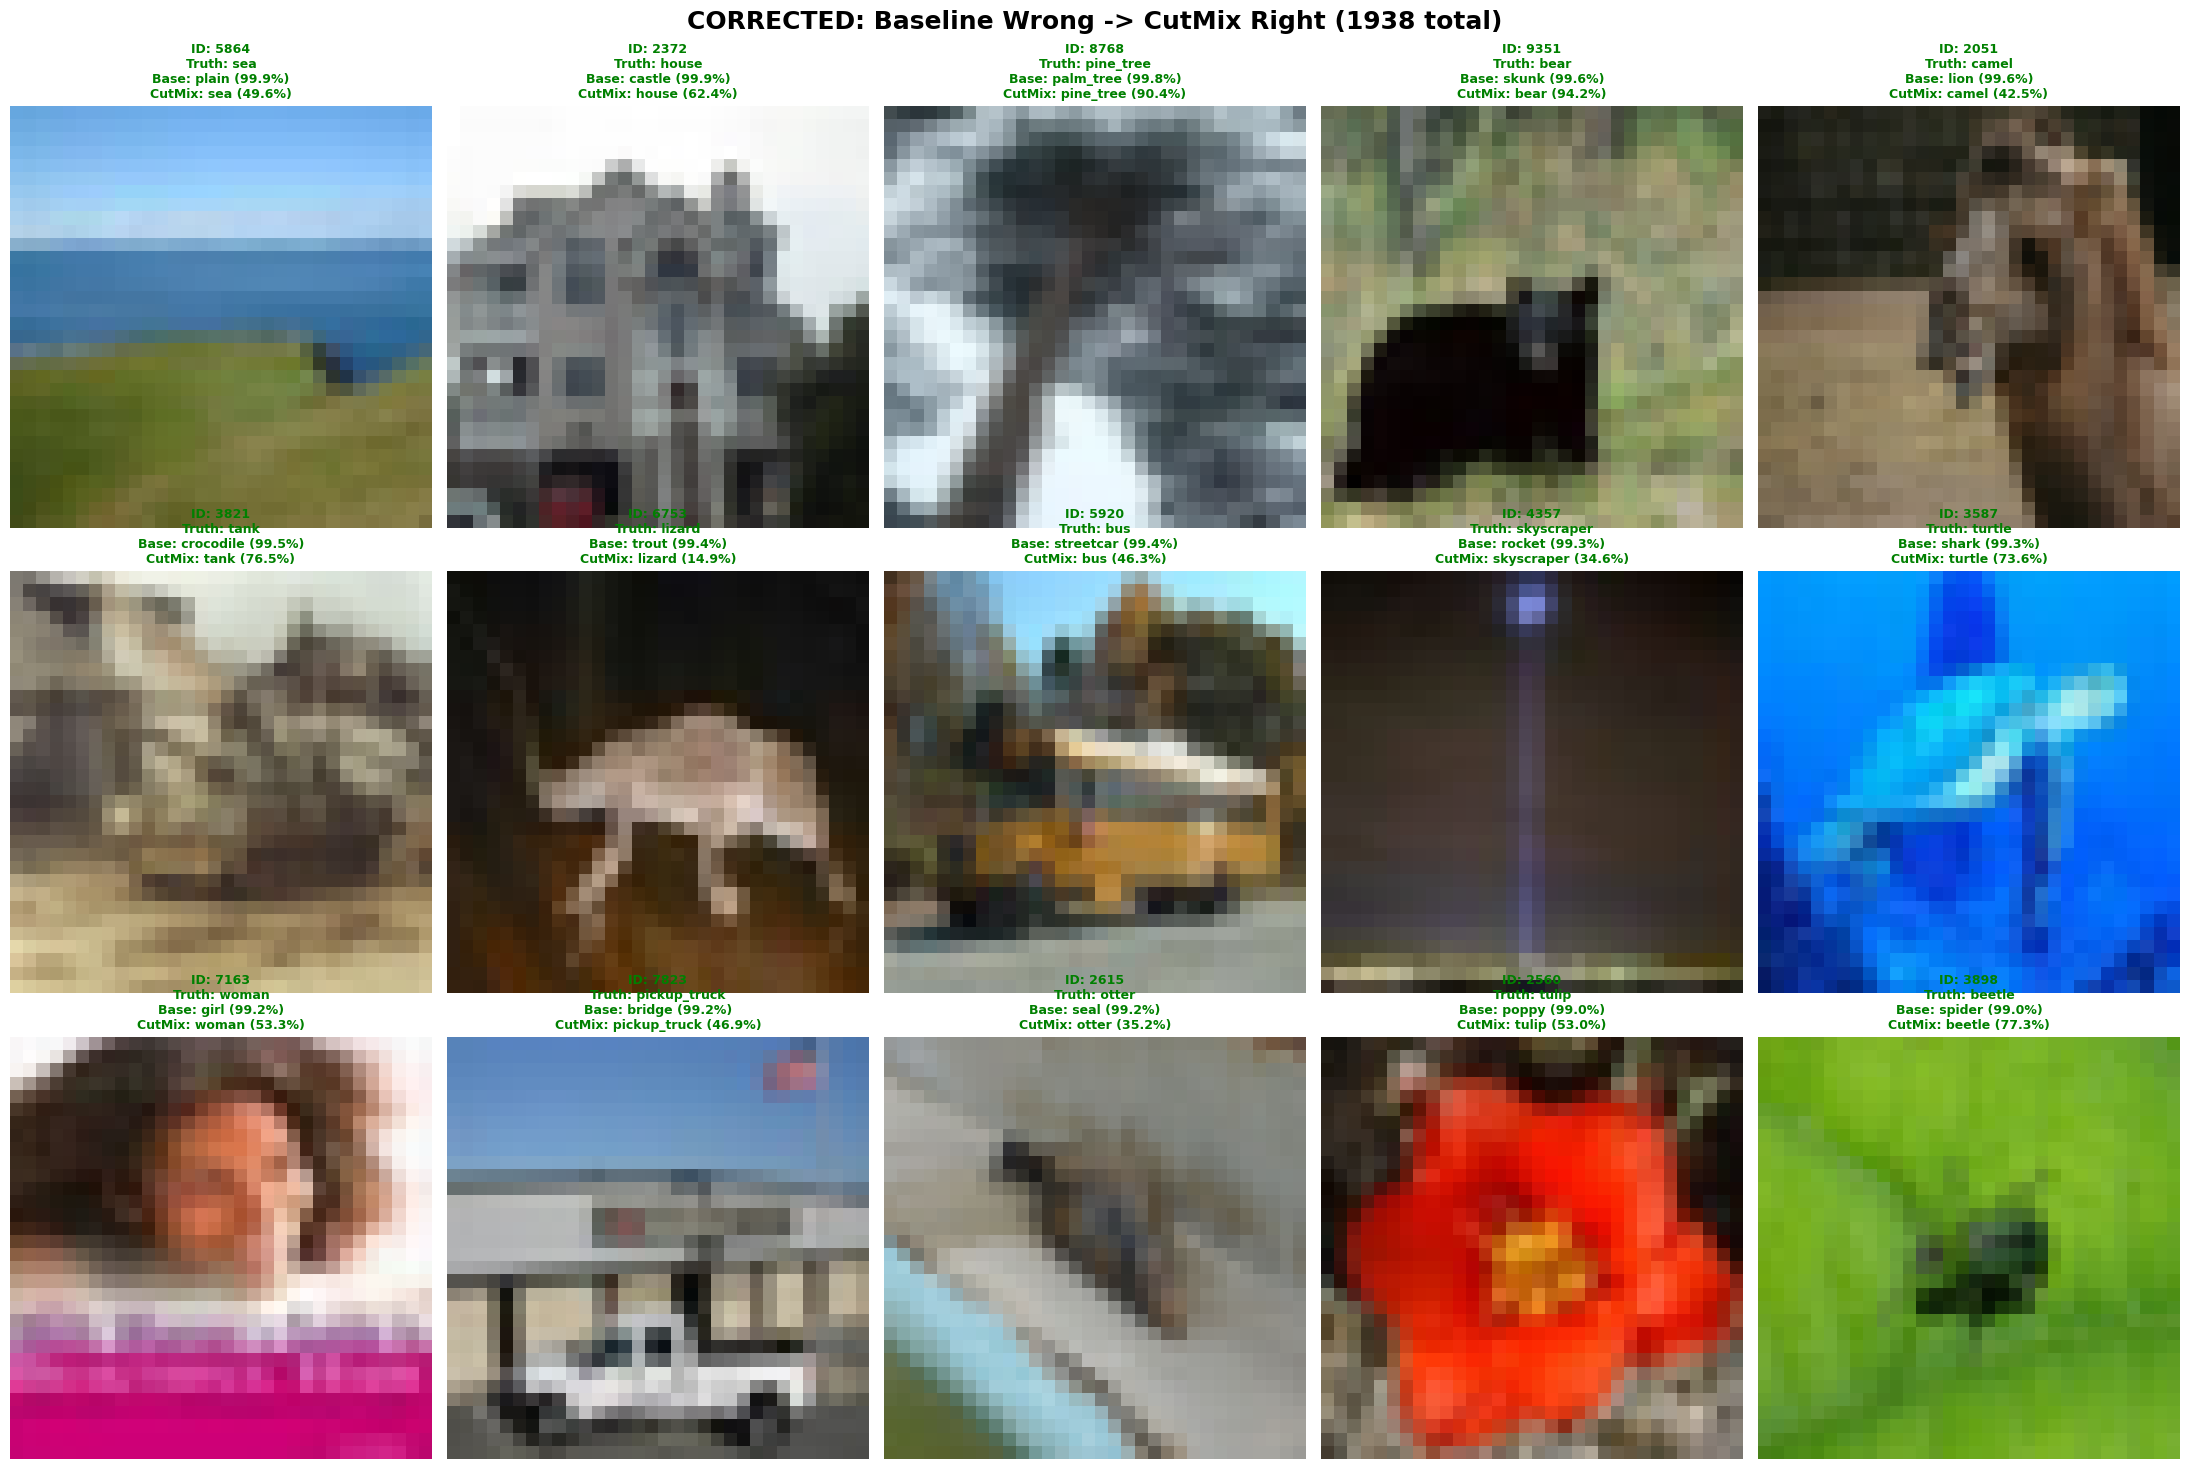

In [21]:
corrected_indices = np.where(corrected)[0]
corrected_sorted = sorted(corrected_indices, key=lambda i: base_confs[i], reverse=True)

num_show = min(15, len(corrected_sorted))
rows = max(1, (num_show + 4) // 5)
fig, axes = plt.subplots(rows, 5, figsize=(22, rows * 5))
if rows == 1:
    axes = np.array(axes).reshape(1, -1)
fig.suptitle(f"CORRECTED: Baseline Wrong -> CutMix Right ({corrected.sum()} total)", fontsize=18, y=0.98, fontweight='bold')

for i, ax in enumerate(axes.flatten()):
    if i < num_show:
        idx = corrected_sorted[i]
        img, _ = test_dataset[idx]
        ax.imshow(unnormalize(img))
        ax.set_title(
            f"ID: {idx}\nTruth: {classes[truths[idx]]}\n"
            f"Base: {classes[base_preds[idx]]} ({base_confs[idx]*100:.1f}%)\n"
            f"CutMix: {classes[enh_preds[idx]]} ({enh_confs[idx]*100:.1f}%)",
            fontsize=9, fontweight='bold', color='green'
        )
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout(); plt.subplots_adjust(top=0.92)
plt.savefig('corrected_cases.png', dpi=300)
print("Saved 'corrected_cases.png'")
plt.show()

## C6. Visualize Worsened Cases

Saved 'worsened_cases.png'


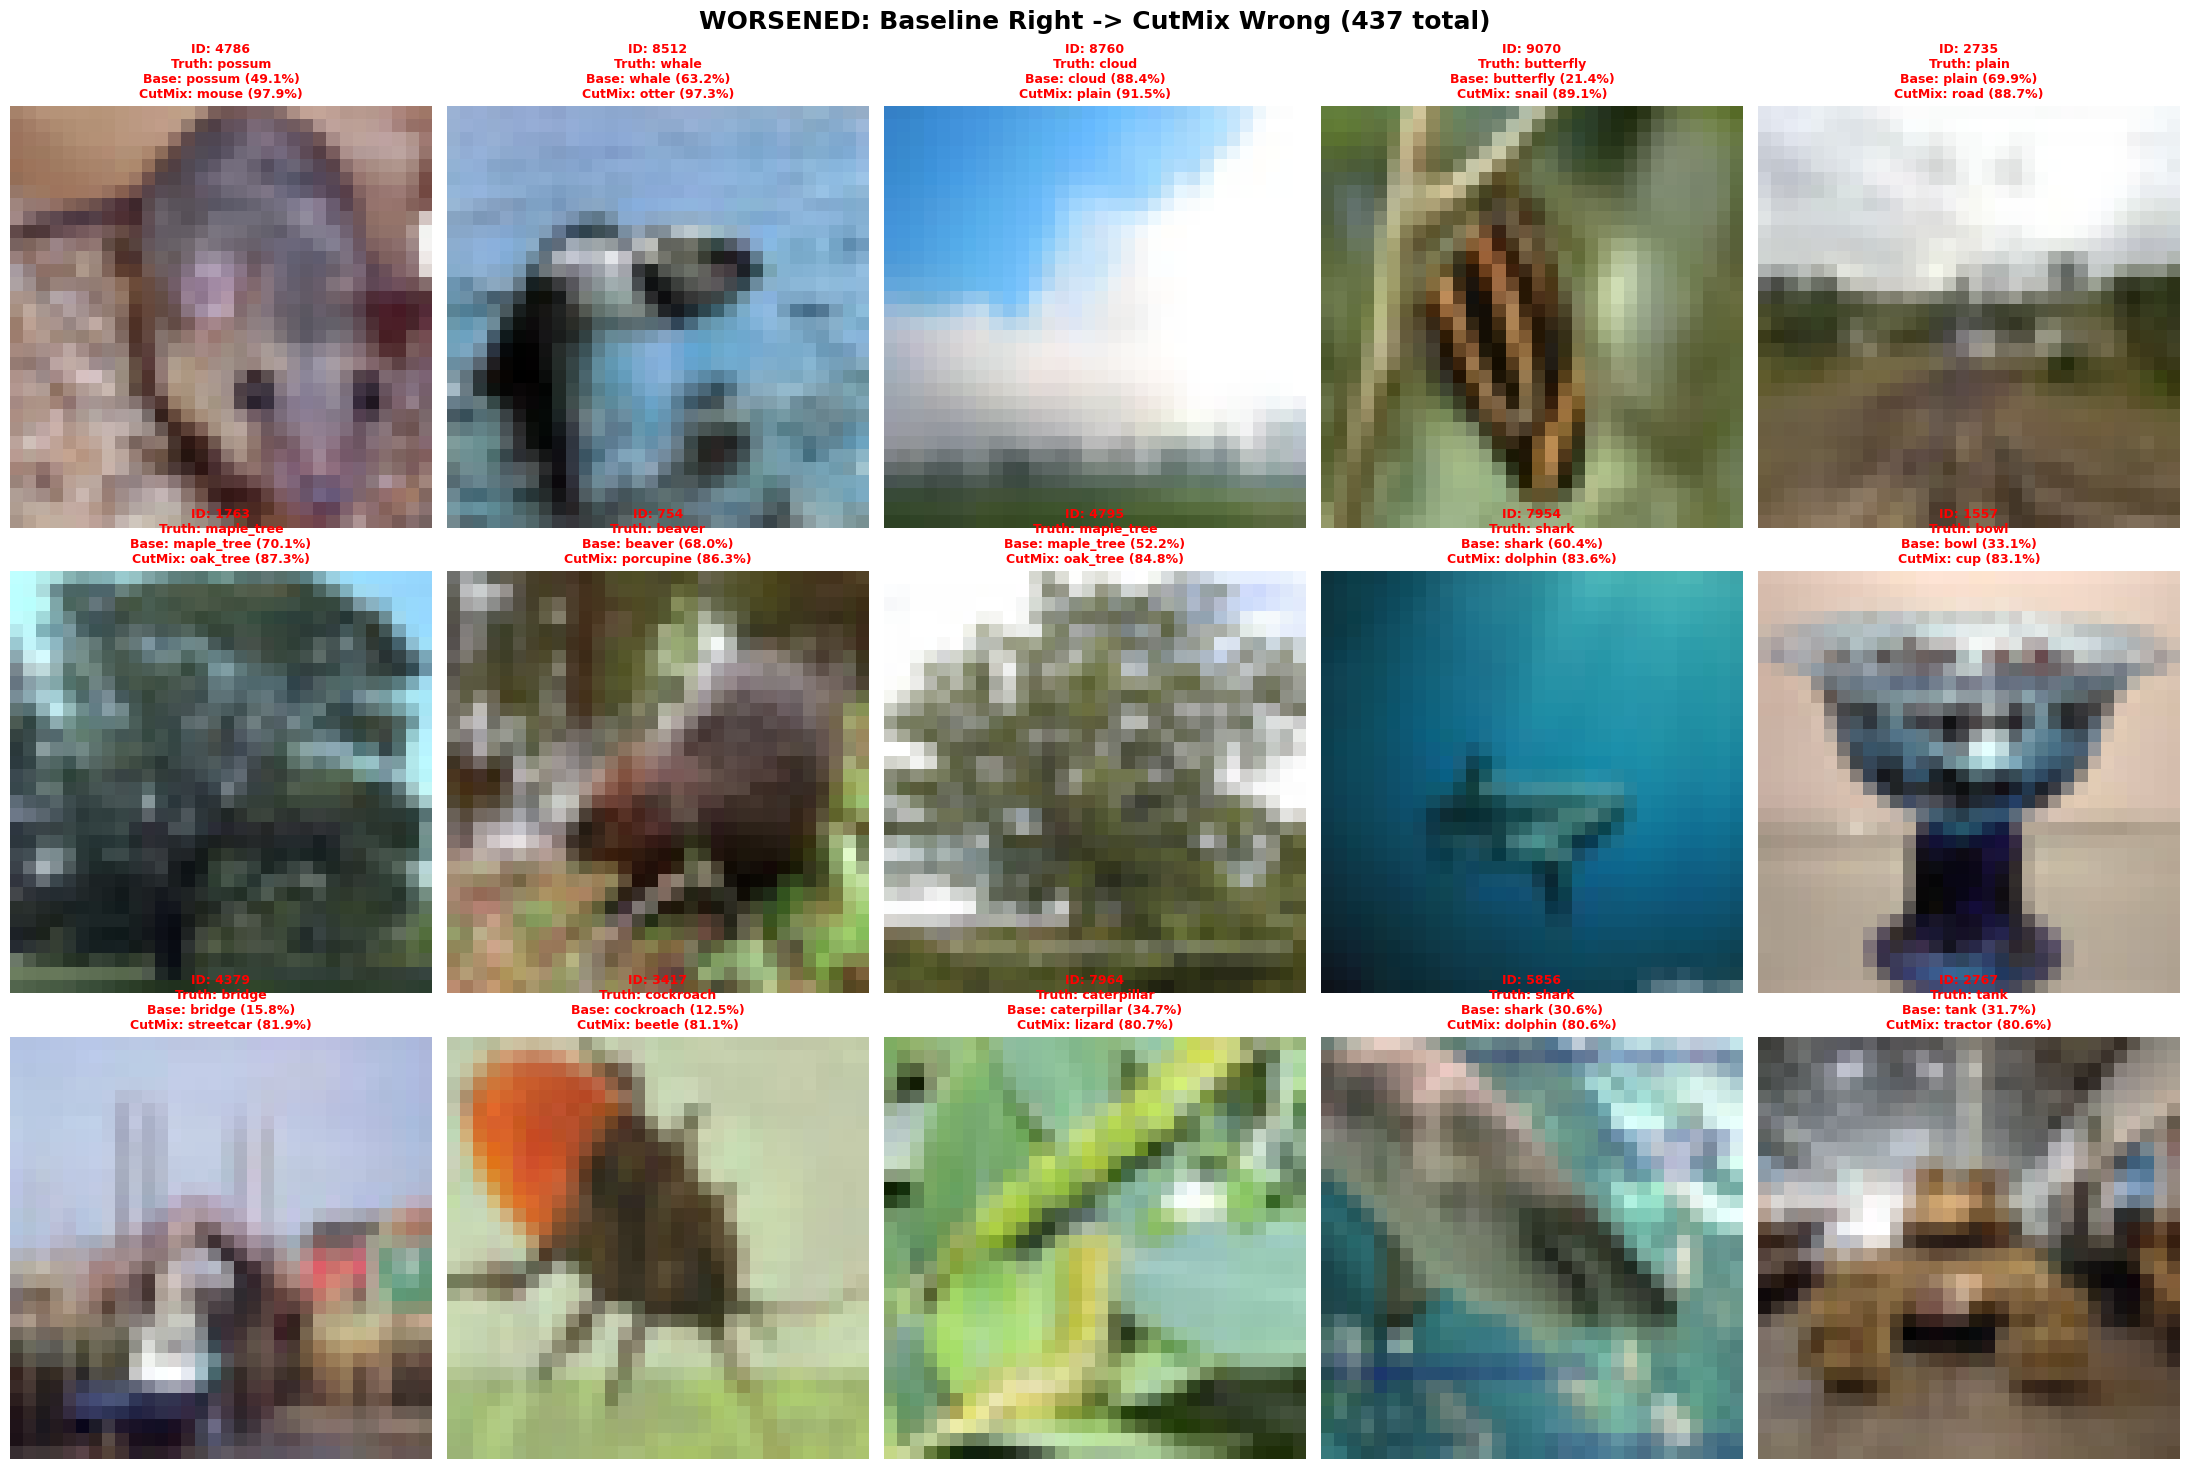

In [22]:
worsened_indices = np.where(worsened)[0]

if len(worsened_indices) > 0:
    worsened_sorted = sorted(worsened_indices, key=lambda i: enh_confs[i], reverse=True)
    num_show_w = min(15, len(worsened_sorted))
    rows_w = max(1, (num_show_w + 4) // 5)
    fig, axes = plt.subplots(rows_w, 5, figsize=(22, rows_w * 5))
    if rows_w == 1:
        axes = np.array(axes).reshape(1, -1)
    fig.suptitle(f"WORSENED: Baseline Right -> CutMix Wrong ({worsened.sum()} total)", fontsize=18, y=0.98, fontweight='bold')

    for i, ax in enumerate(axes.flatten()):
        if i < num_show_w:
            idx = worsened_sorted[i]
            img, _ = test_dataset[idx]
            ax.imshow(unnormalize(img))
            ax.set_title(
                f"ID: {idx}\nTruth: {classes[truths[idx]]}\n"
                f"Base: {classes[base_preds[idx]]} ({base_confs[idx]*100:.1f}%)\n"
                f"CutMix: {classes[enh_preds[idx]]} ({enh_confs[idx]*100:.1f}%)",
                fontsize=9, fontweight='bold', color='red'
            )
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout(); plt.subplots_adjust(top=0.92)
    plt.savefig('worsened_cases.png', dpi=300)
    print("Saved 'worsened_cases.png'")
    plt.show()
else:
    print("No worsened cases — CutMix didn't break any previously correct predictions!")

## C7. Confidence Distribution Comparison

Saved 'confidence_distribution_comparison.png'


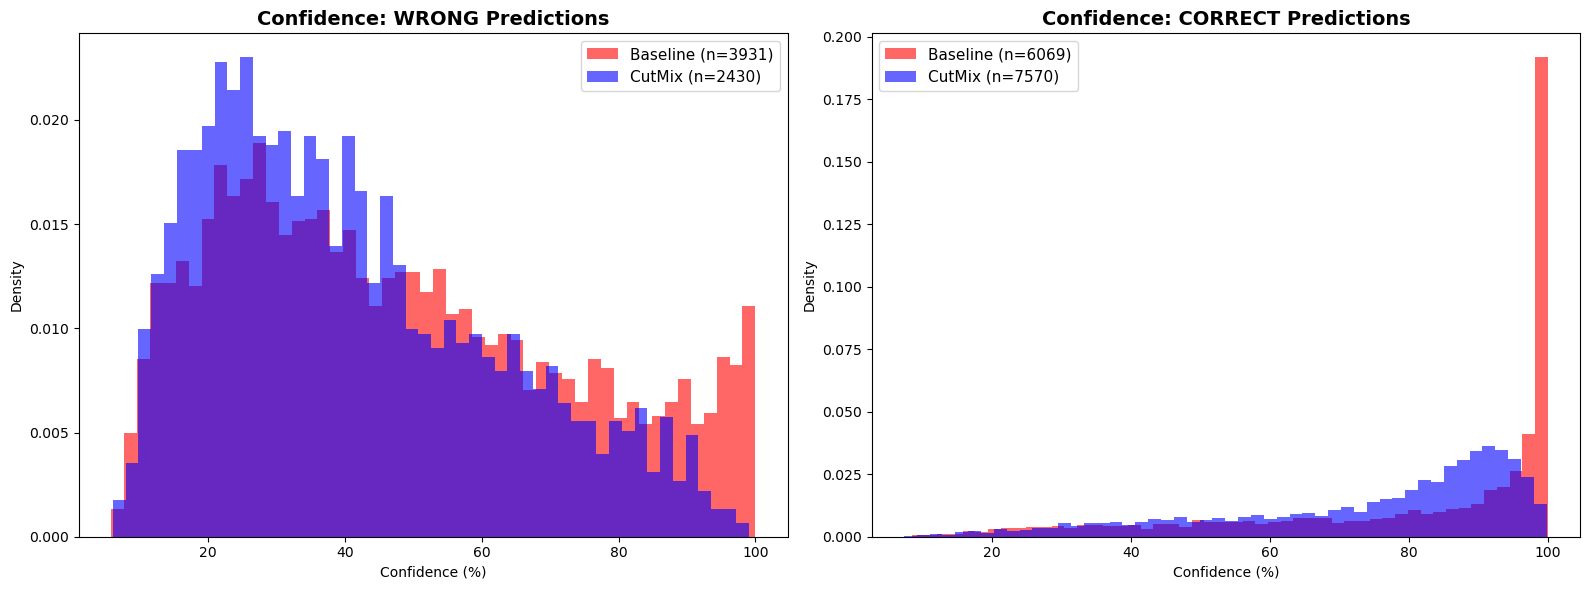

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wrong predictions
base_wrong_c = base_confs[~base_correct] * 100
enh_wrong_c  = enh_confs[~enh_correct] * 100
axes[0].hist(base_wrong_c, bins=50, alpha=0.6, color='red',  label=f'Baseline (n={len(base_wrong_c)})', density=True)
axes[0].hist(enh_wrong_c,  bins=50, alpha=0.6, color='blue', label=f'CutMix (n={len(enh_wrong_c)})', density=True)
axes[0].set_title('Confidence: WRONG Predictions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Confidence (%)'); axes[0].set_ylabel('Density'); axes[0].legend(fontsize=11)

# Correct predictions
base_right_c = base_confs[base_correct] * 100
enh_right_c  = enh_confs[enh_correct] * 100
axes[1].hist(base_right_c, bins=50, alpha=0.6, color='red',  label=f'Baseline (n={len(base_right_c)})', density=True)
axes[1].hist(enh_right_c,  bins=50, alpha=0.6, color='blue', label=f'CutMix (n={len(enh_right_c)})', density=True)
axes[1].set_title('Confidence: CORRECT Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence (%)'); axes[1].set_ylabel('Density'); axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('confidence_distribution_comparison.png', dpi=300)
print("Saved 'confidence_distribution_comparison.png'")
plt.show()

---
This plot compares the distribution of confidence scores for incorrect predictions made by the baseline model and the CutMix-augmented model. The baseline model exhibits a heavy tail of high-confidence errors, including a substantial number of misclassifications with confidence exceeding 80% and even approaching 100%.

In contrast, the CutMix model significantly suppresses high-confidence incorrect predictions. The confidence distribution for wrong predictions under CutMix is shifted toward lower values, indicating improved calibration. Although misclassifications still occur, the model is generally less confident when it is wrong.

This reduction in overconfident errors is particularly important from a robustness and reliability perspective, as high-confidence incorrect predictions pose a greater risk in real-world deployment.

---


This plot shows the confidence distribution for correctly classified test samples under the baseline and CutMix models. The baseline model produces a large spike near 100% confidence, indicating that many correct predictions are made with extreme confidence.

The CutMix model exhibits a more spread-out confidence distribution for correct predictions, with fewer predictions concentrated at very high confidence levels. This suggests that CutMix encourages the model to be more cautious and less overconfident, even when predictions are correct.

Importantly, this change does not indicate degraded performance, but rather improved confidence calibration. The model learns to distribute probability mass more realistically, which is desirable in safety-critical or uncertainty-aware applications.

## C8. High-Confidence Error Count Comparison

HIGH-CONFIDENCE WRONG PREDICTIONS (lower is better)
   Threshold |   Baseline |     CutMix |     Change
------------------------------------------------------------
    >= 50%    |       1642 |        736 |      -906 ↓
    >= 60%    |       1199 |        496 |      -703 ↓
    >= 70%    |        846 |        294 |      -552 ↓
    >= 80%    |        558 |        161 |      -397 ↓
    >= 90%    |        315 |         44 |      -271 ↓
    >= 95%    |        194 |          9 |      -185 ↓
    >= 99%    |         54 |          1 |       -53 ↓
Saved 'high_confidence_errors_comparison.png'


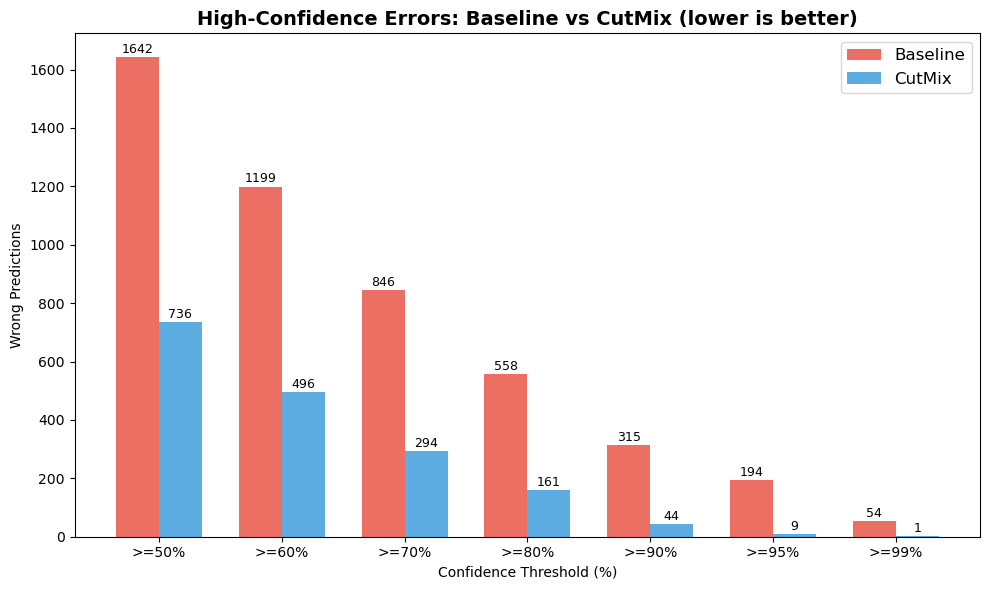

In [24]:
thresholds = [50, 60, 70, 80, 90, 95, 99]

print("=" * 60)
print("HIGH-CONFIDENCE WRONG PREDICTIONS (lower is better)")
print("=" * 60)
print(f"{'Threshold':>12} | {'Baseline':>10} | {'CutMix':>10} | {'Change':>10}")
print("-" * 60)

base_counts, enh_counts = [], []
for t in thresholds:
    bn = int(((~base_correct) & (base_confs * 100 >= t)).sum())
    en = int(((~enh_correct)  & (enh_confs  * 100 >= t)).sum())
    base_counts.append(bn); enh_counts.append(en)
    arrow = "\u2193" if en < bn else "\u2191" if en > bn else "="
    print(f"    >={t:>3}%    | {bn:>10} | {en:>10} | {en-bn:>+9} {arrow}")

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(thresholds))
w = 0.35
b1 = ax.bar(x - w/2, base_counts, w, label='Baseline', color='#e74c3c', alpha=0.8)
b2 = ax.bar(x + w/2, enh_counts,  w, label='CutMix',   color='#3498db', alpha=0.8)
ax.set_xlabel('Confidence Threshold (%)'); ax.set_ylabel('Wrong Predictions')
ax.set_title('High-Confidence Errors: Baseline vs CutMix (lower is better)', fontsize=14, fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels([f'>={t}%' for t in thresholds]); ax.legend(fontsize=12)
for bar in b1:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                xytext=(0,3), textcoords="offset points", ha='center', fontsize=9)
for bar in b2:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                xytext=(0,3), textcoords="offset points", ha='center', fontsize=9)
plt.tight_layout()
plt.savefig('high_confidence_errors_comparison.png', dpi=300)
print("Saved 'high_confidence_errors_comparison.png'")
plt.show()

---
This plot quantifies the number of incorrect predictions exceeding various confidence thresholds. For all thresholds (≥50% to ≥99%), the CutMix model consistently produces fewer high-confidence errors than the baseline model.

The difference becomes increasingly pronounced at higher confidence levels. Notably, at confidence thresholds above 90% and 95%, the CutMix model nearly eliminates high-confidence mistakes, while the baseline model continues to produce a substantial number of such errors.

These results demonstrate that CutMix is particularly effective at mitigating the most concerning failure mode identified in the baseline analysis: highly confident but incorrect predictions. This directly addresses the calibration and robustness issues observed earlier.

## C9. Per-Class Accuracy Change

TOP 10 MOST IMPROVED CLASSES
   1. otter                 26% -> 59%  (+33%)
   2. camel                 52% -> 83%  (+31%)
   3. mouse                 35% -> 65%  (+30%)
   4. girl                  28% -> 58%  (+30%)
   5. raccoon               57% -> 86%  (+29%)
   6. tractor               62% -> 89%  (+27%)
   7. woman                 34% -> 60%  (+26%)
   8. table                 44% -> 70%  (+26%)
   9. ray                   42% -> 67%  (+25%)
  10. rabbit                34% -> 59%  (+25%)

TOP 10 MOST REGRESSED CLASSES
   1. oak_tree              70% -> 68%  (-2%)
   2. maple_tree            63% -> 62%  (-1%)
   3. chair                 84% -> 87%  (+3%)
   4. wardrobe              90% -> 93%  (+3%)
   5. bowl                  50% -> 54%  (+4%)
   6. motorcycle            92% -> 96%  (+4%)
   7. apple                 82% -> 86%  (+4%)
   8. plate                 72% -> 77%  (+5%)
   9. sea                   80% -> 85%  (+5%)
  10. sunflower             88% -> 93%  (+5%)
Saved 'per

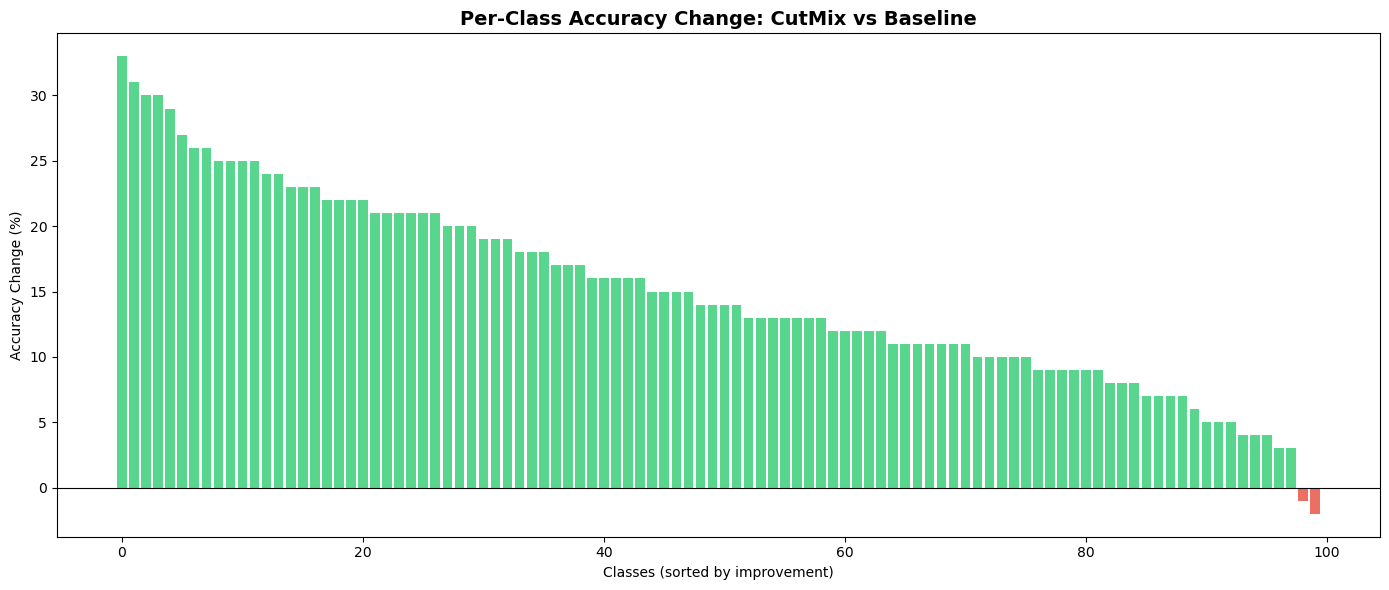

In [25]:
base_class_acc = np.zeros(100)
enh_class_acc  = np.zeros(100)
class_counts   = np.zeros(100)

for i in range(len(truths)):
    c = truths[i]
    class_counts[c] += 1
    if base_correct[i]: base_class_acc[c] += 1
    if enh_correct[i]:  enh_class_acc[c] += 1

base_class_acc = base_class_acc / class_counts * 100
enh_class_acc  = enh_class_acc  / class_counts * 100
class_delta    = enh_class_acc - base_class_acc

top_improved  = np.argsort(class_delta)[::-1][:10]
top_regressed = np.argsort(class_delta)[:10]

print("TOP 10 MOST IMPROVED CLASSES")
print("=" * 55)
for rank, c in enumerate(top_improved):
    print(f"  {rank+1:>2}. {classes[c]:<20s}  {base_class_acc[c]:.0f}% -> {enh_class_acc[c]:.0f}%  ({class_delta[c]:+.0f}%)")

print("\nTOP 10 MOST REGRESSED CLASSES")
print("=" * 55)
for rank, c in enumerate(top_regressed):
    print(f"  {rank+1:>2}. {classes[c]:<20s}  {base_class_acc[c]:.0f}% -> {enh_class_acc[c]:.0f}%  ({class_delta[c]:+.0f}%)")

fig, ax = plt.subplots(figsize=(14, 6))
sorted_deltas = np.sort(class_delta)[::-1]
colors = ['#2ecc71' if d >= 0 else '#e74c3c' for d in sorted_deltas]
ax.bar(range(100), sorted_deltas, color=colors, alpha=0.8)
ax.set_xlabel('Classes (sorted by improvement)'); ax.set_ylabel('Accuracy Change (%)')
ax.set_title('Per-Class Accuracy Change: CutMix vs Baseline', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig('per_class_accuracy_change.png', dpi=300)
print("Saved 'per_class_accuracy_change.png'")
plt.show()

---
This plot illustrates the change in per-class accuracy when transitioning from the baseline model to the CutMix-augmented model. Most classes exhibit a positive accuracy gain, with some classes improving by more than 20–30 percentage points.

The widespread improvement across classes suggests that CutMix acts as a strong regularizer, helping the model generalize better across diverse visual categories. A small number of classes experience slight degradation, indicating a trade-off where enforcing robustness may marginally affect performance on certain classes.

Overall, the net effect of CutMix is strongly positive, improving performance consistency across classes rather than optimizing for a small subset of easy categories.

## C10. Side-by-Side Grad-CAM Comparison

Saved 'gradcam_side_by_side.png'


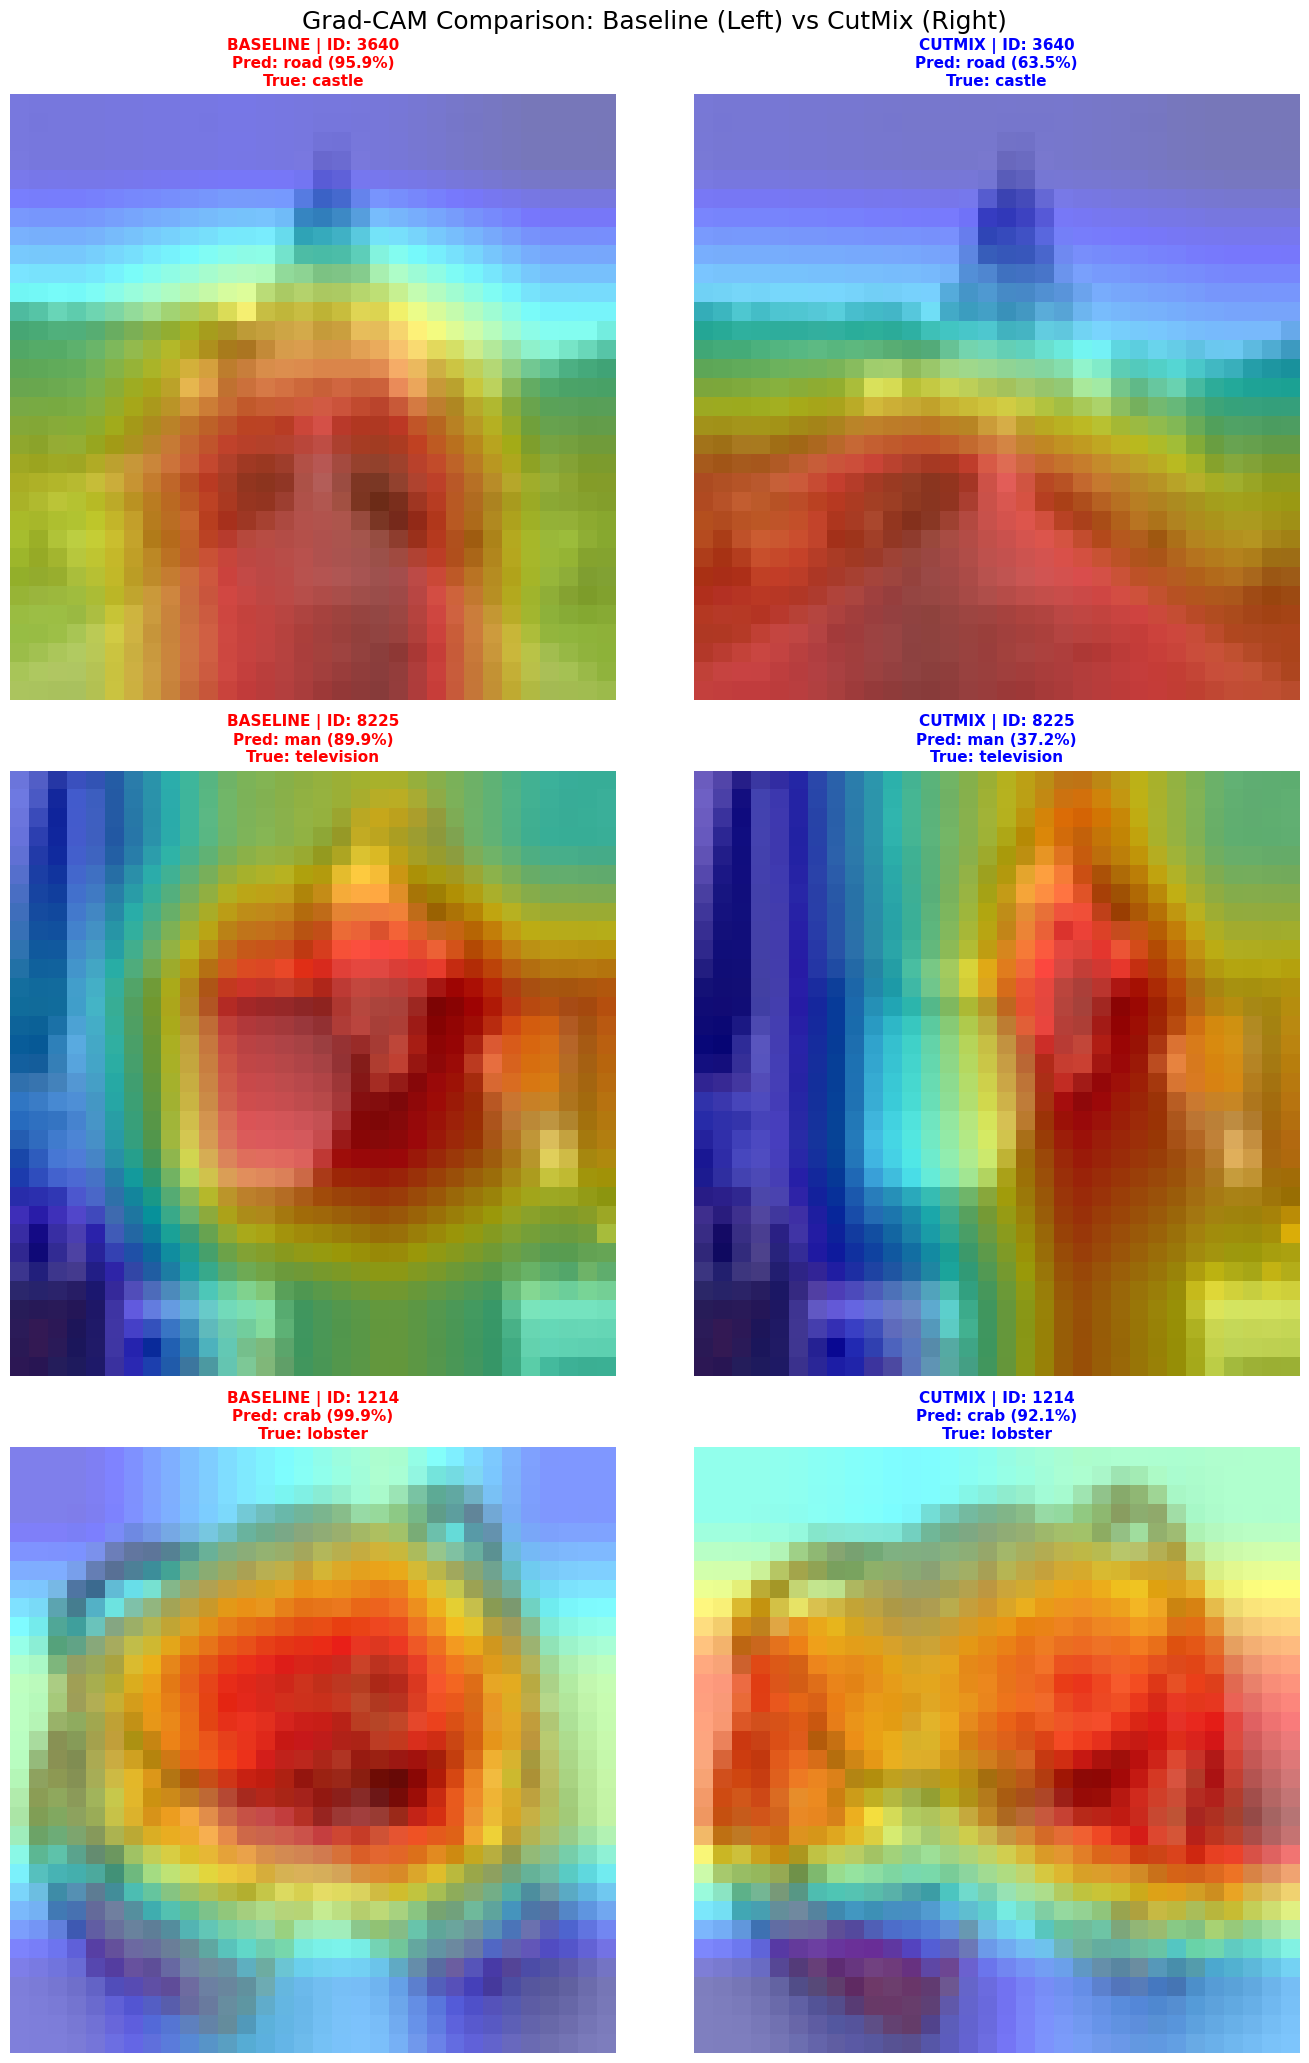

In [26]:
# For each original failure case that's still wrong in CutMix,
# show baseline vs CutMix Grad-CAM side by side

still_wrong_both = [tid for tid in selected_ids
                    if not base_correct[tid] and not enh_correct[tid]]

if still_wrong_both:
    n_cases = len(still_wrong_both)
    fig, axes = plt.subplots(n_cases, 2, figsize=(14, 7 * n_cases))
    if n_cases == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle("Grad-CAM Comparison: Baseline (Left) vs CutMix (Right)", fontsize=18, y=0.98)

    # Baseline Grad-CAM
    baseline_model.eval()
    base_cam = GradCAM(model=baseline_model, target_layers=[baseline_model.layer4[-1]])

    # CutMix Grad-CAM
    cutmix_model.eval()
    cut_cam = GradCAM(model=cutmix_model, target_layers=[cutmix_model.layer4[-1]])

    for row, tid in enumerate(still_wrong_both):
        # Get image
        img_tensor, _ = test_dataset[tid]
        input_t = img_tensor.unsqueeze(0).to(device)
        rgb_img = unnormalize(img_tensor)

        # Baseline
        base_target = [ClassifierOutputTarget(base_preds[tid])]
        base_heatmap = base_cam(input_tensor=input_t, targets=base_target)[0]
        base_vis = show_cam_on_image(rgb_img, base_heatmap, use_rgb=True)

        axes[row, 0].imshow(base_vis)
        axes[row, 0].set_title(
            f"BASELINE | ID: {tid}\nPred: {classes[base_preds[tid]]} ({base_confs[tid]*100:.1f}%)\n"
            f"True: {classes[truths[tid]]}",
            fontsize=11, fontweight='bold', color='red'
        )
        axes[row, 0].axis('off')

        # CutMix
        enh_target = [ClassifierOutputTarget(enh_preds[tid])]
        enh_heatmap = cut_cam(input_tensor=input_t, targets=enh_target)[0]
        enh_vis = show_cam_on_image(rgb_img, enh_heatmap, use_rgb=True)

        axes[row, 1].imshow(enh_vis)
        axes[row, 1].set_title(
            f"CUTMIX | ID: {tid}\nPred: {classes[enh_preds[tid]]} ({enh_confs[tid]*100:.1f}%)\n"
            f"True: {classes[truths[tid]]}",
            fontsize=11, fontweight='bold', color='blue'
        )
        axes[row, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig('gradcam_side_by_side.png', dpi=300)
    print("Saved 'gradcam_side_by_side.png'")
    plt.show()
else:
    print("All original failure cases were corrected by CutMix!")

---
This figure presents side-by-side Grad-CAM visualizations for selected failure cases under the baseline model (left) and the CutMix model (right). In the baseline model, Grad-CAM often highlights broad, diffuse regions or background textures, indicating reliance on spurious cues such as foreground dominance or low-frequency patterns.

Under CutMix, attention maps become more spatially distributed and less concentrated on misleading regions. In several cases, the predicted confidence is also substantially reduced, reflecting increased uncertainty when the model encounters ambiguous visual evidence.

These Grad-CAM comparisons suggest that CutMix encourages the model to rely on more distributed and context-aware features, reducing overconfidence and improving interpretability. This qualitative evidence complements the quantitative reduction in high-confidence errors observed earlier.

## C11. Final Summary

In [27]:
print()
print("=" * 60)
print("          FINAL COMPARISON SUMMARY")
print("=" * 60)
print(f"  Baseline Test Accuracy:       {base_correct.mean()*100:>6.2f}%")
print(f"  CutMix   Test Accuracy:       {enh_correct.mean()*100:>6.2f}%")
print(f"  Accuracy Improvement:         {(enh_correct.mean()-base_correct.mean())*100:>+6.2f}%")
print("-" * 60)
print(f"  Samples Corrected:            {corrected.sum():>5d}")
print(f"  Samples Worsened:             {worsened.sum():>5d}")
print(f"  Net Samples Improved:         {corrected.sum()-worsened.sum():>+5d}")
print("-" * 60)

base_hc = int(((~base_correct) & (base_confs >= 0.90)).sum())
enh_hc  = int(((~enh_correct)  & (enh_confs  >= 0.90)).sum())
print(f"  Wrong with >=90% conf (Base): {base_hc:>5d}")
print(f"  Wrong with >=90% conf (Cut):  {enh_hc:>5d}")
print(f"  Reduction in overconf errors: {base_hc-enh_hc:>+5d}")
print("-" * 60)

bwi = np.where(both_wrong)[0]
if len(bwi) > 0:
    print(f"  Avg wrong conf (Baseline):    {base_confs[bwi].mean()*100:>6.1f}%")
    print(f"  Avg wrong conf (CutMix):      {enh_confs[bwi].mean()*100:>6.1f}%")
print("=" * 60)


          FINAL COMPARISON SUMMARY
  Baseline Test Accuracy:        60.69%
  CutMix   Test Accuracy:        75.70%
  Accuracy Improvement:         +15.01%
------------------------------------------------------------
  Samples Corrected:             1938
  Samples Worsened:               437
  Net Samples Improved:         +1501
------------------------------------------------------------
  Wrong with >=90% conf (Base):   315
  Wrong with >=90% conf (Cut):     44
  Reduction in overconf errors:  +271
------------------------------------------------------------
  Avg wrong conf (Baseline):      47.8%
  Avg wrong conf (CutMix):        40.8%
